# Housekeeping

In [190]:
#packages below

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tabulate import tabulate
from IPython.display import Latex

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Lasso, LassoCV 
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import LogisticRegression, ElasticNet, ElasticNetCV
from sklearn.metrics import classification_report
from sklearn.preprocessing import normalize
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier



import seaborn as sns

# Data Cleaning Functions

In [2]:
#rename columns in df using list of names
def renameCol(df, new_names):
    if len(df.columns) != len(new_names):
        raise ValueError("Number of new column names does not match number of columns in dataframe.")
    
    df.columns = new_names
    return df

In [3]:
#Specific to FRED data
def clean(dfs, keep_cols, start_date, end_date):
    cleaned_dfs = []  # Initialize an empty list to store cleaned dataframes
    for i, df in enumerate(dfs):
        name = f'df_{i+1}' # set a name for the dataframe
        
        #keep only certain columns
        existing_cols = [col for col in keep_cols if col in df.columns]
        if existing_cols:
            df = df.loc[:, existing_cols]
        
        #convert index datetime
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')

        #select date range
        df = df.loc[start_date:end_date]

        #backfill all empties & make sure that df['value'] is numeric
        df = df.replace('.',np.nan)
        df = df.fillna(method='backfill')
        df['value'] = pd.to_numeric(df['value'], downcast='float')

        #create year year variable
        df['Year'] = pd.PeriodIndex(df.index, freq='Y').to_timestamp().year
        
        #group by variable
        df = df.groupby(by=['Year']).mean()
        
        duplicates = df.index.duplicated()

        # If there are any duplicates, loop over them and combine the duplicate rows
        if any(duplicates):
            for idx in df.index[duplicates]:
                # Get all the rows with this index
                dup_rows = df.loc[idx]
                # Calculate the mean of all the rows with this index
                mean_row = dup_rows.mean()
                # Drop the old rows with this index
                df = df.drop(idx)
                # Add the new row with the mean value
                df.loc[idx] = mean_row
        
        #rename 'value' to the name of the dataframe
        df = df.rename(columns={'value':name})
        cleaned_dfs.append(df)  # Add cleaned dataframe to the list
    return cleaned_dfs


In [4]:
def cleanInvalid(df):
    assert isinstance(df, pd.DataFrame)
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)
    return df[indices_to_keep].astype(np.float64)

In [5]:
#change to %change
def percentChange(df):
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['value'] = df['value'].pct_change()
    df.dropna(how='any')
    return df

In [6]:
def joinDfs(variableDfs):
    # Find the longest dataframe in the list
    max_len = max(len(df) for df in variableDfs)
    longest_df = next(df for df in variableDfs if len(df) == max_len)
    variableDfs.remove(longest_df)
    # Join the dataframes using the index of the longest dataframe
    dfJoined = longest_df.join(variableDfs, how='outer')
    
    dfJoined.fillna(value=np.nan, inplace=True)
    
    return dfJoined

In [213]:
#detect multicolinearity for a dataframe
def detectMulti(df):
    
    df = df.dropna(how='any')
    
    # Check for missing values
    if df.isnull().sum().sum() > 0:
        print('Warning: Missing values found in the dataset. Please handle missing values before detecting multicollinearity.')
    
    # Identify the numerical columns
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    
    # Calculate the correlation matrix for the numerical columns
    corr_matrix = df[num_cols].corr()
    
    """# Visualize the correlation matrix using a heatmap
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=True, fmt='.1f', square=True)
    plt.title('Correlation Matrix')
    plt.show()"""
    
    # Check for columns with high correlation
    threshold = 0.8 # define the threshold for high correlation
    corr_matrix = corr_matrix.abs() # convert all values to absolute values
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)) # select upper triangle of correlation matrix
    collinear_cols = [column for column in upper.columns if any(upper[column] > threshold)] # identify columns with high correlation
    
    # Visualize the correlation matrix using a heatmap
    sns.heatmap(upper, cmap='coolwarm', center=0, annot=True, fmt='.1f', square=True)
    plt.title('Correlation Matrix')
    plt.show()
    
    if len(collinear_cols) == 0:
        print('No columns with high correlation found.')
    else:
        print('Columns with high correlation:', collinear_cols)
    
    return collinear_cols


In [8]:
# Replace objects using one hot
def oneHot(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            # Use one hot encoding for string/non-numeric columns
            onehot_encoder = OneHotEncoder(sparse=False)
            encoded = onehot_encoder.fit_transform(df[col].values.reshape(-1, 1))
            # Create new column names based on original column and categories
            col_names = [f"{col}_{category}" for category in onehot_encoder.categories_[0]]
            # Create new columns from encoded data
            new_cols = pd.DataFrame(encoded, columns=col_names)
            # Add new columns to dataframe and drop original column
            df = pd.concat([df, new_cols], axis=1)
            df.drop(col, axis=1, inplace=True)
            print(f"{col} has been one-hot encoded and the following columns have been added: {', '.join(col_names)}")
        elif df[col].dtype == 'bool':
            # Use pandas get_dummies function for boolean columns
            new_cols = pd.get_dummies(df[col], prefix=col)
            # Add new columns to dataframe and drop original column
            df = pd.concat([df, new_cols], axis=1)
            df.drop(col, axis=1, inplace=True)
            print(f"{col} has been converted to dummy variables and the following columns have been added: {', '.join(new_cols.columns)}")
    return df

In [9]:
#change all boolean to dummy variable
def bool2Dummy(df):
    
    bool_cols = df.select_dtypes(include='bool').columns
    if bool_cols.empty:
        print("No boolean columns to convert.")
        return df
    else:
        dummy_df = pd.get_dummies(df, columns=bool_cols, drop_first=True)
        return dummy_df

In [10]:
#Make values bool
def colBool(df, columns,val):
    
    for col in columns:
        
        df[col] = df[col].fillna(False)
        df[col] = df[col] > val
        df[col] = df[col].astype('bool')
    return df

In [11]:
#Make strings bool
def mapBool(df, col_name, search_list):
    return df[col_name].str.contains('|'.join(search_list)).fillna(False)

In [12]:
#Change datatype in column
def changeColType(df,colList,dType):
    for col in colList:
        df[col] = df[col].astype(dType)

In [13]:
#normalize dataframe
def normDf(df):
    scaler = StandardScaler()
    df_norm = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_norm
    

In [14]:
#replace values with NaN
def colNaN(df, columns, valList, negative=False):
    for col in columns:
        if negative:
            df[col] = np.where(df[col].isin(valList) | (df[col] < 0), np.nan, df[col])
        else:
            df[col] = np.where(df[col].isin(valList), np.nan, df[col])
    return df

In [15]:
#excludes rows with certain values in columns
def excludeVal(df,col,val,start):
    if str(val).startswith(start):
        df = df.loc[~df[col].astype(str).str.startswith(start)]
    else:
        df.drop(df.loc[df[col]==val].index, inplace=True)
    return df

def includeVal(df,col,val):
    df = df[df[col].isin(val)]
    return df

In [16]:
#drop all columns with a certain type
def removeType(df,pandastype):
    remove_cols = df.select_dtypes(include=pandastype).columns
    # drop columns with string values
    df_dropped = df.drop(remove_cols, axis=1)
    print('dropped: \n'+str(df_dropped))
    return df_dropped

In [17]:
#normal column dropping, but better
def dropCol(df, cols_to_drop):
    # Check which columns exist in the dataframe
    cols_to_drop = [col for col in cols_to_drop if col in df.columns]
    # Drop the existing columns
    df = df.drop(cols_to_drop, axis=1)
    # Report which columns were successfully dropped
    if cols_to_drop:
        print(f"Successfully dropped columns: {', '.join(cols_to_drop)}")
    return df


In [18]:
def dfDict(df, dictionary):
    for dict1 in dictionary:
        year_mask = df['YEAR'].isin(dictionary[dict1].keys())
        df.loc[year_mask, dict1] = df.loc[year_mask, 'YEAR'].map(dictionary[dict1])
    return df


# Analysis Functions

In [19]:
#Split training and testing sets
def splitSet(df, varY, test_size=0.2):
    y = df[varY]
    X = df.drop(varY, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    return X_train, X_test, y_train, y_test


In [20]:
#Create every combo of scatter plot
def scatterMult(df,k,method):
    
    for i, col1 in enumerate(df.columns[:-1]):
        
        for j, col2 in enumerate(df.columns[i+1:-1]):
            
            plt.scatter(df[col1], df[col2], c=df[k])
            plt.xlabel(col1)
            plt.ylabel(col2)
            plt.title(col1+col2+method)
            plt.show()

In [21]:
def plotTimeline(df, col_list,title):
    # Check if 'YEAR' column exists, else use index as x-axis
    if 'YEAR' in df.columns:
        x_axis = df['YEAR']
    else:
        x_axis = df.index

    # Plot each column on the timeline
    for col_name in col_list:
        plt.plot(x_axis, df[col_name], label=col_name)
    
    # Shade the area between 2007 and 2008
    plt.fill_between(x_axis, min(df.min()), max(df.max()), where=(x_axis > 2007) & (x_axis < 2010), alpha=0.2, color ='red',label='Great Recession')
    
    # Add legend and axis labels
    plt.legend()
    plt.title(title)
    plt.xlabel('Year')
    plt.ylabel('Percent of Sample')
    plt.show()


## PCA & Clustering

In [22]:
#PCA table
def pcaTable(df, n):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    
    df = normDf(df)
    df = df.dropna()
    pca = PCA(n_components=n)
    pca.fit(df)
    components = pd.DataFrame(pca.components_, columns=df.columns)
    explained_variance_ratio = pca.explained_variance_ratio_
    
    print("Explained Variance Ratio:")
    print(explained_variance_ratio)
    print(pca.components_)
    print(tabulate(components, headers='keys', tablefmt='latex_booktabs'))

In [23]:
def genPercent(df, cols, vals):
    # Create a new dataframe to hold the results
    result_df = pd.DataFrame()

    # Loop through each year and calculate the percentage of values matching the values of interest
    for year in df['YEAR'].unique():
        year_data = df[df['YEAR'] == year]
        num_matching = year_data[cols].isin(vals).sum()
        total_num = year_data.shape[0]
        percent_matching = num_matching / total_num
        result_df.loc[year, cols] = percent_matching
    result_df = result_df[cols].copy()
    
    print(result_df.describe())
    return result_df

In [24]:
#Kmeans
def kmean(df, numClus):
    
    print(list(df))
    
    #Cluster
    kClustering = KMeans(n_clusters=numClus)
    kClustering.fit(df)
    k = 'KMLABEL'
    df[k] = kClustering.labels_
    
    #plot
    scatterMult(df,k,'KMeans')

## Regressions

In [25]:
def compareRegW(df, varY, wcol):
    X = df.drop(varY, axis=1)
    y = df[varY]
    w = df[wcol]
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2)
    
    models = {
        'OLS': LinearRegression(),
        'Lasso': Lasso(),
        'Ridge': Ridge(),
        'ElasticNet': ElasticNet()
    }
    
    coeffs = pd.DataFrame()
    accuracy = pd.DataFrame(columns=['Train R2', 'Test R2', 'Test RMSE'], index=models.keys())
    
    for name, model in models.items():
        model.fit(X_train, y_train, sample_weight=w_train)
        coeffs[name] = pd.Series(model.coef_, index=X_train.columns)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        accuracy.loc[name, 'Train R2'] = r2_score(y_train, train_pred, sample_weight=w_train)
        accuracy.loc[name, 'Test R2'] = r2_score(y_test, test_pred, sample_weight=w_test)
        accuracy.loc[name, 'Test RMSE'] = np.sqrt(mean_squared_error(y_test, test_pred, sample_weight=w_test))
        plt.scatter(y_test, test_pred, alpha=0.5, label=name)
    
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray', label='Ideal')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Comparison of Regression Models')
    plt.legend()
    plt.show()
    
    print('Regression coefficients:\n', coeffs)
    print('\nTest accuracy:\n', accuracy)


In [26]:
def compareReg(df, varY):
    X = df.drop(varY, axis=1)
    y = df[varY]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    models = {
        'OLS': LinearRegression(),
        'Lasso': Lasso(),
        'Ridge': Ridge(),
        'ElasticNet': ElasticNet()
    }
    
    coeffs = pd.DataFrame()
    accuracy = pd.DataFrame(columns=['Train R2', 'Test R2', 'Test RMSE'], index=models.keys())
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        coeffs[name] = pd.Series(model.coef_, index=X_train.columns)
        
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        accuracy.loc[name, 'Train R2'] = r2_score(y_train, train_pred)
        accuracy.loc[name, 'Test R2'] = r2_score(y_test, test_pred)
        accuracy.loc[name, 'Test RMSE'] = np.sqrt(mean_squared_error(y_test, test_pred))
        plt.scatter(y_test, test_pred, alpha=0.5, label=name)
    
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='gray', label='Ideal')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Comparison of Regression Models')
    plt.legend()
    plt.show()
    
    print('Regression coefficients:\n', coeffs)
    print('\nTest accuracy:\n', accuracy)

#Compare OLS,Ridge,LASSO
def compare_regression_methods(df, varY, l1_ratio=0.5):
    alphas = np.linspace(1e-6, 1, num=50)

    df = df.dropna(how='any')
    
    X_train, X_test, y_train, y_test = splitSet(df, varY, test_size=0.2)
    
    X = X_train
    # Fit the OLS model
    olsReg = LinearRegression()
    olsReg.fit(X_train, y_train)

    # Fit the Lasso, Ridge, and Elastic Net models
    lassoReg = make_pipeline(StandardScaler(), LassoCV(alphas=alphas, cv=5))
    ridgeReg = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=5))
    elasticReg = make_pipeline(StandardScaler(), ElasticNetCV(alphas=alphas, cv=5, l1_ratio=l1_ratio))
    lassoReg.fit(X_train, y_train)
    ridgeReg.fit(X_train, y_train)
    elasticReg.fit(X_train, y_train)

    # Get the coefficient values for each method
    ols_coeffs = olsReg.coef_
    lasso_coeffs = lassoReg['lassocv'].coef_
    ridge_coeffs = ridgeReg['ridgecv'].coef_
    elastic_coeffs = elasticReg['elasticnetcv'].coef_

    # Create a dataframe comparing the coefficients
    coef_comp = pd.DataFrame({
        'var': X.columns, 
        'var_ols': ols_coeffs, 
        'var_lasso': lasso_coeffs, 
        'var_ridge': ridge_coeffs,
        'var_elastic': elastic_coeffs
    })
    
    return coef_comp

In [122]:
#LASSO w. weights

def lasso_with_weights(df, target_col, weight_col):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
        df.drop(columns=[target_col]), df[target_col], df[weight_col], test_size=0.2, random_state=42)

    # Create and fit the lasso model
    lasso = Lasso(alpha=0.1)
    lasso.fit(X_train, y_train, sample_weight=w_train)

    # Print the accuracy score on the test set
    y_pred = lasso.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred.round())
    print("Accuracy Score: {:.2f}%".format(acc_score * 100))
    print("R^2 Value: "+str(r2_score(y_test, y_pred.round())))
    print("RMSE Value: "+str(np.sqrt(mean_squared_error(y_test,y_pred.round())))) 
    
    coef_comp = pd.DataFrame({
        'var': X_train.columns,
        'LASSO Coeff': lasso.coef_
    })
    
    # Check if any coefficients are exactly zero
    zero_coef = sum(lasso.coef_ == 0)
    
    if zero_coef > 0:
        print("There are {} coefficients that are exactly zero.".format(zero_coef))

    else:
        print("There are no coefficients that are exactly zero.")
    
    return coef_comp


In [27]:
# find best lasso alphas
def lassoAlpha(alphas, X_train, X_test, y_train, y_test):
    best_alpha = None
    MSE = float("inf")
    cv_errors = []
    coef_list = []
    
    for a in alphas:
        # define pipeline object
        lassoReg = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha= a * X_train.shape[0]))
        # run LASSO regression
        lassoReg.fit(X_train, y_train)

        # obtain predicted values of output
        y_pred = lassoReg.predict(X_test)

        # compute mean squared error
        cv_errors.append(mean_squared_error(y_test, y_pred))
        # store coefficients
        coef_list.append(lassoReg['lasso'].coef_)

        # store value of alpha that minimizes the mean squared error
        if mean_squared_error(y_test, y_pred) < MSE:
            #update MSE and best_alpha if new minimum is found
            MSE = mean_squared_error(y_test, y_pred)
            best_alpha = a

    #print best alpha
    print('Best alpha is', best_alpha)

    # plot
    plt.plot(alphas, cv_errors, '*')
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Mean Squared Error')

    #show plot
    plt.show()

In [28]:
#Polynomial
def poly_reg(X, y, degrees):
    for degree in degrees:
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X)

        # Fit the model
        model = LinearRegression().fit(X_poly, y)

        # Make predictions
        y_pred = model.predict(X_poly)

        # Calculate R-squared
        r2 = r2_score(y, y_pred)

        # Poly coeff
        coeffs = model.coef_

        # Create labels for the polynomial terms
        labels = ['1']
        for i in range(1, degree+1):
            labels.append(f"x^{i}")

        # Print the results
        print(f"Degree {degree} polynomial coefficients: {coeffs}")
        print(f"Degree {degree} polynomial labels: {labels}")
        print(f"Degree {degree} polynomial R-squared: {r2:.4f}\n")


In [29]:
#Probit, not comparing anything
def probitReg(df, varY):
    df = df.dropna(how='any')
    # Split the data into training and testing sets
    y = df[varY]
    X = df.drop(varY, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

    # Fit the probit model on the training data
    probit_model = sm.Probit(y_train, X_train)
    probit_results = probit_model.fit()

    # Calculate the accuracy on the testing data
    y_pred = probit_results.predict(X_test).round()
    accuracy = accuracy_score(y_test, y_pred)

    # Print the summary of the probit model
    print(probit_results.summary())

    # Return the probit coefficients and accuracy
    return probit_results.params, accuracy



In [30]:
#PROBIT WITH WEIGHTS

def fit_probit_model(df, valY, wcol, test_size=0.2):
    
    y = df[valY]
    w = df[wcol]
    X = df.drop(columns=[valY, wcol])
    

    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=test_size)

    X_train = sm.add_constant(X_train)
    X_test = sm.add_constant(X_test)

    probit_model = sm.Probit(y_train, X_train, w_train)
    results =  probit_model.fit()

    print(results.summary())

    accuracy = model.score(X_test, y_test, w_test)
    print("Test Accuracy: {:.2f}%".format(accuracy * 100))

    return results



#Probit
def probitModels(df, target_col, lasso_alpha=1.0, ridge_alpha=1.0):
    df = df.dropna(how='any')
    # Create X and y
    X = df.drop(columns=target_col)
    y = df[target_col]
    
    # Fit Lasso Probit model
    lasso_model = Lasso(alpha=lasso_alpha)
    lasso_model.fit(X, y)
    lasso_y_pred = np.where(lasso_model.predict(X) > 0.5, 1, 0)
    lasso_report = classification_report(y, lasso_y_pred, output_dict=True)
    
    # Fit Ridge Probit model
    ridge_model = Ridge(alpha=ridge_alpha)
    ridge_model.fit(X, y)
    ridge_y_pred = np.where(ridge_model.predict(X) > 0.5, 1, 0)
    ridge_report = classification_report(y, ridge_y_pred, output_dict=True)
    
    # Fit OLS Probit model
    ols_model = LogisticRegression(penalty='none')
    ols_model.fit(X, y)
    ols_y_pred = ols_model.predict(X)
    ols_report = classification_report(y, ols_y_pred, output_dict=True)
    
    # Combine results into dictionary
    results = {
        'Lasso Probit': lasso_report,
        'Ridge Probit': ridge_report,
        'OLS Probit': ols_report
    }
    
    return results

from sklearn.linear_model import LogisticRegression

def weighted_logistic_regression(df, varY, wcol, penalty='l2', C=1.0):

    # Extract the response variable and weights from the input data
    y = df[varY]
    weights = df[wcol]
    
    # Fit the weighted logistic regression model using scikit-learn
    model = LogisticRegression(penalty=penalty, C=C, class_weight='balanced')
    result = model.fit(df.drop([varY, wcol], axis=1), y, sample_weight=weights)
    
    
    print(result.summary())
    return model


In [132]:
#Logistic reg

def logReg(df, target_col, weight_col,penalty='12',C=1.0):
    # Separate the target variable and input features
    X = df.drop(columns=[target_col, weight_col])
    y = df[target_col]
    w = df[weight_col]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, w, test_size=0.2, random_state=42)

    # Train the model with the training data
    model = LogisticRegression()
    model.fit(X_train, y_train, sample_weight=w_train)

    # Make predictions on the test data and calculate accuracy
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred, sample_weight=w_test)

    # Calculate false positive rate and true positive rate for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1], sample_weight=w_test)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print the accuracy and coefficients (regressors)
    print(f"Accuracy: {accuracy}")
    print("Coefficients:")
    for col, coef in zip(X.columns, model.coef_[0]):
        print(f"{col}: {coef}")
    
    print(classification_report(y_test, y_pred))


def run_random_forest(df, wcol, varY):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(df.drop(columns=[varY]), df[varY], df[wcol], test_size=0.2, random_state=42)

    # Create a random forest regressor
    rfr = RandomForestRegressor(n_estimators=100, max_features='sqrt')

    # Fit the regressor to the training data
    rfr.fit(X_train, y_train, w_train)

    # Make predictions on the test data
    y_pred = rfr.predict(X_test)

    # Calculate in-sample accuracy
    y_pred_train = rfr.predict(X_train)
    in_sample_accuracy = rfr.score(X_train, y_train, w_train)

    # Calculate out-of-sample accuracy
    out_of_sample_accuracy = rfr.score(X_test, y_test, w_test)

    # Print feature importances
    feature_importances = pd.Series(rfr.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.nlargest(10)
    print(f"Feature importances:\n{feature_importances_sorted}\n")

    # Print summary metrics
    print(f"In-sample accuracy: {in_sample_accuracy:.4f}")
    print(f"Out-of-sample accuracy: {out_of_sample_accuracy:.4f}")
    print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"Root mean squared error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

    # Plot the feature importances
    feature_importances_sorted.plot(kind='barh')
    plt.show()

    # Return the random forest regression
    return rfr



In [222]:
#Random forest updated
def run_random_forest(df, wcol, varY):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(df.drop(columns=[varY]), df[varY], df[wcol], test_size=0.2, random_state=42)

    # Create a random forest classifier
    rfc = RandomForestClassifier(n_estimators=5, max_features='sqrt')

    # Fit the classifier to the training data
    rfc.fit(X_train, y_train, w_train)

    # Make predictions on the test data
    y_pred = rfc.predict(X_test)

    # Calculate in-sample accuracy
    y_pred_train = rfc.predict(X_train)
    in_sample_accuracy = rfc.score(X_train, y_train, w_train)

    # Calculate out-of-sample accuracy
    out_of_sample_accuracy = rfc.score(X_test, y_test, w_test)

    # Print feature importances
    feature_importances = pd.Series(rfc.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.nlargest(10)
    print(f"Feature importances:\n{feature_importances_sorted}\n")

    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)

    # Print summary metrics
    print(f"In-sample accuracy: {in_sample_accuracy:.4f}")
    print(f"Out-of-sample accuracy: {out_of_sample_accuracy:.4f}")
    print(f"Mean absolute error: {mean_absolute_error(y_test, y_pred):.4f}")
    print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.4f}")
    print(f"Root mean squared error: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    print(f"F1 score: {f1:.4f}")

    # Plot the feature importances
    feature_importances_sorted.plot(kind='barh')
    plt.show()

    # Return the random forest classifier
    return rfc


# FRED DATA

In [33]:
#set up full fred
from full_fred.fred import Fred
apiKey = '/Users/joanne/Desktop/ECON1680/Project1/fred_apikey.txt'
fred = Fred(apiKey)
fred.get_api_key_file()


'/Users/joanne/Desktop/ECON1680/Project1/fred_apikey.txt'

### Fetch Data

In [39]:
#NYC 
UNRATE = fred.get_series_df('NYUR')
#Condo Price Index for New York, New York
CONDO = fred.get_series_df('NYXRCSA')
#Current General Business Conditions; Diffusion Index for New York 
BIZ = fred.get_series_df('GACDISA066MSFRBNY')
#Consumer Price Index for All Urban Consumers: Rent of Primary Residence in New York-Newark-Jersey City, NY-NJ-PA
RENTCPI = fred.get_series_df('CUURA101SEHA')
#Income Inequality in New York County, NY
INEQ = fred.get_series_df('2020RATIO036061')
#Subprime
SUBPRIME = fred.get_series_df('EQFXSUBPRIME036061')

#NATIONAL
RGDP = fred.get_series_df('GDPC1')
#10y 2y treasury spread
YIELD = fred.get_series_df('T10Y2Y')

CONDO = percentChange(CONDO)
RENTCPI = percentChange(RENTCPI)
RGDP = percentChange(RGDP)



In [40]:
tickerList = ['NYUR', 'NYXRCSA', 'GACDISA066MSFRBNY', 'CUURA101SEHA', '2020RATIO036061', 'GDPC1', 'T10Y2Y']
variablesString = ['UNRATE', 'CONDO', 'BIZ', 'RENTCPI', 'INEQ', 'RGDP', 'YIELD']

In [41]:
# put dataframes in a list
variableDfs = [UNRATE, CONDO, BIZ, RENTCPI, INEQ, RGDP, YIELD]



In [42]:
keep_cols = ['date','value']
start_date = '2000-1-1'
end_date = '2021-12-31'
cvariableDfs = clean(variableDfs, keep_cols, start_date, end_date)

type(cvariableDfs)


list

In [43]:

dfFred = joinDfs(cvariableDfs)
dfFred = renameCol(dfFred,variablesString)
dfFred.head()

UNRATE     CONDO        BIZ   RENTCPI  INEQ      RGDP     YIELD
Year                                                                   
2000  4.508333  0.012578        NaN  0.003216   NaN  0.007198 -0.229654
2001  4.875000  0.009780 -13.300000  0.003365   NaN  0.000435  1.191801
2002  6.200000  0.011462   7.141667  0.003749   NaN  0.004945  1.975632
2003  6.400000  0.008507  15.900000  0.003482   NaN  0.010578  2.362797
2004  5.791667  0.013373  28.766666  0.003815   NaN  0.008287  1.889160

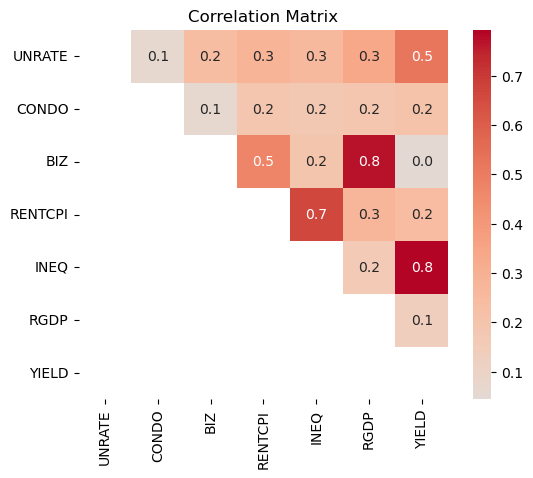

No columns with high correlation found.


[]

In [214]:
detectMulti(dfFred)

In [45]:
#Consider dropping INEQ due to high correlation
pcaTable(dfFred.drop('INEQ',axis=1), 3)
#test w. INEQb
pcaTable(dfFred, 3)

Explained Variance Ratio:
[0.37220535 0.28078938 0.19346943]
[[ 0.40652746 -0.38656044 -0.5441966  -0.21871683 -0.5440648   0.21286795]
 [ 0.51084185  0.01483768  0.31014332 -0.5673331   0.4322127   0.36600065]
 [-0.2429937  -0.57345814  0.13555408 -0.4942838   0.05887283 -0.5881685 ]]
\begin{tabular}{rrrrrrr}
\toprule
    &    UNRATE &      CONDO &       BIZ &   RENTCPI &       RGDP &     YIELD \\
\midrule
  0 &  0.406527 & -0.38656   & -0.544197 & -0.218717 & -0.544065  &  0.212868 \\
  1 &  0.510842 &  0.0148377 &  0.310143 & -0.567333 &  0.432213  &  0.366001 \\
  2 & -0.242994 & -0.573458  &  0.135554 & -0.494284 &  0.0588728 & -0.588169 \\
\bottomrule
\end{tabular}
Explained Variance Ratio:
[0.42907873 0.24564503 0.23164235]
[[-0.5638545  -0.05580527  0.230438   -0.1699793   0.55167496  0.2339409
  -0.4877351 ]
 [ 0.36127332 -0.097546   -0.4513538  -0.14782825  0.39244378 -0.5682161
  -0.39687714]
 [ 0.596773   -0.00981393  0.389777   -0.5322755   0.30014893  0.30190897
   0.1651

PCA results for 2 components are [0.37220535 0.28078938], [0.42907873 0.24564503] (w. w/out INEQ). 

In [46]:
Fred_dict = dfFred.to_dict()
Fred_dict

{'UNRATE': {2000: 4.508333206176758,
  2001: 4.875,
  2002: 6.199999809265137,
  2003: 6.400000095367432,
  2004: 5.791666507720947,
  2005: 4.958333492279053,
  2006: 4.5333333015441895,
  2007: 4.433333396911621,
  2008: 5.4083333015441895,
  2009: 8.366666793823242,
  2010: 8.716667175292969,
  2011: 8.358333587646484,
  2012: 8.625,
  2013: 7.7916669845581055,
  2014: 6.291666507720947,
  2015: 5.233333587646484,
  2016: 4.875,
  2017: 4.633333206176758,
  2018: 4.099999904632568,
  2019: 3.8499999046325684,
  2020: 9.850000381469727,
  2021: 7.016666889190674},
 'CONDO': {2000: 0.012577703222632408,
  2001: 0.009779591113328934,
  2002: 0.011462092399597168,
  2003: 0.008506609126925468,
  2004: 0.013373441062867641,
  2005: 0.01337879616767168,
  2006: 0.0007519506034441292,
  2007: -0.0003394927771296352,
  2008: -0.004207374528050423,
  2009: -0.006591462530195713,
  2010: -0.0012578009627759457,
  2011: -0.0005314217996783555,
  2012: 0.006299063563346863,
  2013: 0.0063862511

# IPUMS DATA

### Dictionaries

In [47]:
#Maps RELATED to relationship with head of household
family_codes = {101: 'Head/Householder', 201: 'Spouse', 202: '2nd/3rd Wife (Polygamous)', 301: 'Child', 302: 'Adopted Child', 303: 'Stepchild', 304: 'Adopted, n.s.', 401: 'Child-in-law', 402: 'Step Child-in-law', 501: 'Parent', 502: 'Stepparent', 601: 'Parent-in-Law', 602: 'Stepparent-in-law', 701: 'Sibling', 702: 'Step/Half/Adopted Sibling', 801: 'Sibling-in-Law', 802: 'Step/Half Sibling-in-law', 901: 'Grandchild', 902: 'Adopted Grandchild', 903: 'Step Grandchild', 904: 'Grandchild-in-law', 1000: 'Other relatives:', 1001: 'Other Relatives', 1011: 'Grandparent', 1012: 'Step Grandparent', 1013: 'Grandparent-in-law', 1021: 'Aunt or Uncle', 1022: 'Aunt,Uncle-in-law', 1031: 'Nephew, Niece', 1032: 'Neph/Niece-in-law', 1033: 'Step/Adopted Nephew/Niece', 1034: 'Grand Niece/Nephew', 1041: 'Cousin', 1042: 'Cousin-in-law', 1051: 'Great Grandchild', 1061: 'Other relatives, nec', 1100: 'Partner, Friend, Visitor', 1110: 'Partner/friend', 1111: 'Friend', 1112: 'Partner', 1113: 'Partner/roommate', 1114: 'Unmarried Partner', 1115: 'Housemate/Roomate', 1120: 'Relative of partner', 1130: 'Concubine/Mistress', 1131: 'Visitor', 1132: 'Companion and family of companion', 1139: 'Allocated partner/friend/visitor'}

#HHTYPE
#Maps HHTYPE to type of family as string
household_codes = {0: 'N/A', 1: 'Married-couple family household', 2: 'Male householder, no wife present', 3: 'Female householder, no husband present', 4: 'Male householder, living alone', 5: 'Male householder, not living alone', 6: 'Female householder, living alone', 7: 'Female householder, not living alone', 9: 'HHTYPE could not be determined'}
#Maps HHTYPE to living alone, with family, non family
hhtype_codes = {0: np.nan, 1: 'Family', 2: 'Family', 3: 'Family', 4: 'Alone', 5: 'Non-Family', 6: 'Alone', 7: 'Non-Family', 9: np.nan}

#EDUC
#Maps to label
education_level_codes = {0: 'Less than High School', 1: 'Less than High School', 2: 'Less than High School', 3: 'Some High school', 4: 'Some High school', 5: 'Some High school', 6: 'High school', 7: 'High school', **{int(i): str(int(i-6)) + ' years of college' for i in range(8, 12+1)}}
#Maps to years in college
yearsCollege_codes = {'0': 0, '1': 0, '2': 0, '3': 0, '4': 0, '5': 0, '6': 0,  '7': 1,'8': 2, '9': 3, '10': 4,'11': 5}
yearsCollege_codes = {int(k): v for k, v in yearsCollege_codes.items()}

### Data

In [48]:
#define path
fPath = '/Users/joanne/Desktop/ECON1680/Project1/'

#define dataframe
dfOriginal = pd.read_csv(os.path.join(fPath,"nyc_large.csv"), encoding='unicode_escape')
print(dfOriginal.head())
print(list(dfOriginal))

   YEAR  SAMPLE  SERIAL  CBSERIAL  NUMPREC   HHWT  HHTYPE        CLUSTER  \
0  2005  200501  695670       367        1   50.0       6  2005006956701   
1  2005  200501  695727      2037        5  158.0       9  2005006957271   
2  2005  200501  695742      2520        2  141.0       7  2005006957421   
3  2005  200501  695742      2520        2  141.0       7  2005006957421   
4  2005  200501  695783      3689        2   79.0       1  2005006957831   

   MET2013  STRATA  GQ  FARM  OWNERSHP  OWNERSHPD  RENT  RENTGRS  \
0    35620   30334   1     1         2         22   840      860   
1    35620   40034   1     1         2         22   800     1040   
2    35620   70234   1     1         2         22  1500     1640   
3    35620   70234   1     1         2         22  1500     1640   
4    35620   90334   1     1         2         22   930      980   

   RENTGRS_CPIU_2010  ROOMS  BUILTYR2  BEDROOMS  PERNUM  PERWT  NCHILD  \
0              960.0      3         5         2       1   52

In [49]:
dfOriginal.describe()

YEAR         SAMPLE         SERIAL      CBSERIAL  \
count  235998.000000  235998.000000  235998.000000  2.359980e+05   
mean     2011.736735  201174.673506  828872.021043  2.979436e+11   
std         3.960187     396.018661   42601.073035  7.157737e+11   
min      2005.000000  200501.000000  695670.000000  2.000000e+00   
25%      2008.000000  200801.000000  794224.000000  4.216128e+05   
50%      2012.000000  201201.000000  833002.000000  8.421870e+05   
75%      2015.000000  201501.000000  863665.000000  1.259936e+06   
max      2018.000000  201801.000000  913645.000000  2.018001e+12   

             NUMPREC           HHWT         HHTYPE       CLUSTER   MET2013  \
count  235998.000000  235998.000000  235998.000000  2.359980e+05  235998.0   
mean        3.274456     129.116628       3.563657  2.011745e+12   35620.0   
std         1.759015      84.742180       2.754442  3.960295e+09       0.0   
min         1.000000       5.000000       1.000000  2.005007e+12   35620.0   
25%         2.000000      71.000000       1.000000  2.008009e+12   35620.0   
50%         3.000000     105.000000       3.000000  2.012008e+12   35620.0   
75%         4.000000     165.000000       5.000000  2.015009e+12   35620.0   
max        20.000000    1746.000000       9.000000  2.018009e+12   35620.0   

              STRATA             GQ      FARM  OWNERSHP      OWNERSHPD  \
count  235998.000000  235998.000000  235998.0  235998.0  235998.000000   
mean   307530.177451       1.007949       1.0       2.0      21.975983   
std    132849.537273       0.107930       0.0       0.0       0.153103   
min     30134.000000       1.000000       1.0       2.0      21.000000   
25%    180034.000000       1.000000       1.0       2.0      22.000000   
50%    380336.000000       1.000000       1.0       2.0      22.000000   
75%    401136.000000       1.000000       1.0       2.0      22.000000   
max    431236.000000       5.000000       1.0       2.0      22.000000   

                RENT        RENTGRS  RENTGRS_CPIU_2010          ROOMS  \
count  235998.000000  235998.000000      230330.000000  235998.000000   
mean     1332.290477    1471.574357        1450.528537       4.191120   
std       723.219012     751.277867         678.520910       1.672479   
min         0.000000       0.000000           4.000000       1.000000   
25%       890.000000    1000.000000        1008.000000       3.000000   
50%      1200.000000    1360.000000        1334.000000       4.000000   
75%      1700.000000    1830.000000        1769.000000       5.000000   
max      3900.000000    5120.000000        4899.000000      21.000000   

            BUILTYR2       BEDROOMS         PERNUM          PERWT  \
count  235998.000000  235998.000000  235998.000000  235998.000000   
mean        3.745028       3.051064       2.094522     141.561789   
std         3.312273       1.105352       1.248883      97.417085   
min         1.000000       1.000000       1.000000       4.000000   
25%         1.000000       2.000000       1.000000      75.000000   
50%         3.000000       3.000000       2.000000     115.000000   
75%         5.000000       4.000000       3.000000     180.000000   
max        23.000000      10.000000      17.000000    2112.000000   

              NCHILD         RELATE       RELATED            SEX  \
count  235998.000000  235998.000000  235998.00000  235998.000000   
mean        0.427999       3.823918     386.67134       1.525318   
std         0.925566       3.725614     379.31084       0.499360   
min         0.000000       1.000000     101.00000       1.000000   
25%         0.000000       1.000000     101.00000       1.000000   
50%         0.000000       3.000000     301.00000       2.000000   
75%         0.000000       3.000000     301.00000       2.000000   
max         9.000000      12.000000    1260.00000       2.000000   

                 AGE         MARRNO         SCHOOL           EDUC  \
count  235998.000000  191400.000000  235998.000000  235998.000000   
me

In [50]:
#Select some specific variables
dropList = ['SAMPLE', 'SERIAL', 'CBSERIAL',
            'RENTGRS', 'RENTGRS_CPIU_2010','HHWT',
            'MET2013','GQ', 'FARM', 'OWNERSHP', 
            'OWNERSHPD','INCWELFR','MIGTYPE1', 'PWMET13','PERNUM']
dfOriginal2 = dfOriginal.drop(dropList,axis=1).copy()
print(list(dfOriginal2))
print(dfOriginal2.shape[0])

['YEAR', 'NUMPREC', 'HHTYPE', 'CLUSTER', 'STRATA', 'RENT', 'ROOMS', 'BUILTYR2', 'BEDROOMS', 'PERWT', 'NCHILD', 'RELATE', 'RELATED', 'SEX', 'AGE', 'MARRNO', 'SCHOOL', 'EDUC', 'EDUCD', 'OCCSOC', 'WORKEDYR', 'INCTOT', 'POVERTY', 'TRANTIME']
235998


In [51]:
#According to documentation, adjust data

dfOriginal2 = colNaN(dfOriginal2, ['INCTOT','RENT'], [9999999],negative=True)
dfOriginal2 = colNaN(dfOriginal2, ['POVERTY'], [0],negative=True)

#Has children, receives welfare, commutes, has been married
dfOriginal2 = colBool(dfOriginal2,['NCHILD','TRANTIME','MARRNO'],0)
#Female = TRUE, in school = TRUE
dfOriginal2 = colBool(dfOriginal2,['SEX','SCHOOL'],2)

dfOriginal2.dtypes

YEAR          int64
NUMPREC       int64
HHTYPE        int64
CLUSTER       int64
STRATA        int64
RENT        float64
ROOMS         int64
BUILTYR2      int64
BEDROOMS      int64
PERWT       float64
NCHILD         bool
RELATE        int64
RELATED       int64
SEX            bool
AGE           int64
MARRNO         bool
SCHOOL         bool
EDUC          int64
EDUCD         int64
OCCSOC       object
WORKEDYR      int64
INCTOT      float64
POVERTY     float64
TRANTIME       bool
dtype: object

In [52]:
#Make some new columns
dfNYC = dfOriginal2.copy()

dfNYC['RELATENAME'] = dfNYC['RELATED'].map(family_codes)
dfNYC['HHNAMES'] = dfNYC['HHTYPE'].map(household_codes)
dfNYC['HHTYPE_2'] = dfNYC['HHTYPE'].map(hhtype_codes)
dfNYC['EDUCNAMES'] = dfNYC['EDUC'].map(education_level_codes)
dfNYC['YCOLLEGE'] = dfNYC['EDUC'].map(yearsCollege_codes)

dfNYC['RCOST'] =  ((dfNYC['RENT']*12/dfNYC['NUMPREC'])/dfNYC['INCTOT'])
dfNYC['RCOST'].replace([np.inf, -np.inf], np.nan, inplace=True)
dfNYC['RCOST'] = dfNYC['RCOST'].where(lambda x: x > 0, np.nan)
dfNYC.loc[dfNYC['RCOST'] > 1, 'RCOST'] = np.nan

print(list(dfNYC))
dfNYC.head()

['YEAR', 'NUMPREC', 'HHTYPE', 'CLUSTER', 'STRATA', 'RENT', 'ROOMS', 'BUILTYR2', 'BEDROOMS', 'PERWT', 'NCHILD', 'RELATE', 'RELATED', 'SEX', 'AGE', 'MARRNO', 'SCHOOL', 'EDUC', 'EDUCD', 'OCCSOC', 'WORKEDYR', 'INCTOT', 'POVERTY', 'TRANTIME', 'RELATENAME', 'HHNAMES', 'HHTYPE_2', 'EDUCNAMES', 'YCOLLEGE', 'RCOST']


YEAR  NUMPREC  HHTYPE        CLUSTER  STRATA    RENT  ROOMS  BUILTYR2  \
0  2005        1       6  2005006956701   30334   840.0      3         5   
1  2005        5       9  2005006957271   40034   800.0      4         1   
2  2005        2       7  2005006957421   70234  1500.0      6         5   
3  2005        2       7  2005006957421   70234  1500.0      6         5   
4  2005        2       1  2005006957831   90334   930.0      3         5   

   BEDROOMS  PERWT  NCHILD  RELATE  RELATED    SEX  AGE  MARRNO  SCHOOL  EDUC  \
0         2   52.0   False       1      101  False   22   False   False     7   
1         3  109.0   False      11     1115  False   19   False   False     0   
2         4  146.0   False       1      101  False   27   False   False    10   
3         4  145.0   False      11     1115  False   27   False   False    10   
4         2   75.0   False       1      101  False   26   False   False    10   

   EDUCD  OCCSOC  WORKEDYR   INCTOT  POVERTY  TRANTIME         RELATENAME  \
0     71  232011         3  28000.0    283.0      True   Head/Householder   
1      2       0         1      0.0      1.0     False  Housemate/Roomate   
2    101  419099         3  81000.0    501.0      True   Head/Householder   
3    101  211020         3  35000.0    351.0      True  Housemate/Roomate   
4    101  172081         3  58000.0    501.0      True   Head/Householder   

                                HHNAMES    HHTYPE_2              EDUCNAMES  \
0      Female householder, living alone       Alone            High school   
1        HHTYPE could not be determined         NaN  Less than High School   
2  Female householder, not living alone  Non-Family     4 years of college   
3  Female householder, not living alone  Non-Family     4 years of college   
4       Married-couple family household      Family     4 years of college   

   YCOLLEGE     RCOST  
0         1  0.360000  
1         0       NaN  
2         4  0.111111  
3         4  0.257143  
4         4  0.096207

In [53]:
#make more descriptive
nycNames_codes = {
    "BUILTYR2": "BUILTYEAR",
    "TRANTIME": "COMMUTES",
    "RELATENAME": "HHPOSITION",
    "SEX":"FEMALE",
    "HHNAMES": "HHDES",
    "HHTYPE_2": "ROOMMATES",
    "EDUCNAMES": "EDUCATIONLVL",
    "YCOLLEGE": "COLLEGEYRS"
}
dfNYC = dfNYC.rename(nycNames_codes,axis=1)
print(list(dfNYC))

['YEAR', 'NUMPREC', 'HHTYPE', 'CLUSTER', 'STRATA', 'RENT', 'ROOMS', 'BUILTYEAR', 'BEDROOMS', 'PERWT', 'NCHILD', 'RELATE', 'RELATED', 'FEMALE', 'AGE', 'MARRNO', 'SCHOOL', 'EDUC', 'EDUCD', 'OCCSOC', 'WORKEDYR', 'INCTOT', 'POVERTY', 'COMMUTES', 'HHPOSITION', 'HHDES', 'ROOMMATES', 'EDUCATIONLVL', 'COLLEGEYRS', 'RCOST']


In [54]:
#all military codes start with 55. drop.
dfNYC = excludeVal(dfNYC,'OCCSOC',-9999,'55')
#keep only non-students
dfNYC = includeVal(dfNYC,'SCHOOL', [False] )

In [55]:
dropList = ['HHTYPE','CLUSTER',
            'RELATE','RELATED','EDUC',
            'EDUCD','OCCSOC','SCHOOL']
dfNYC = dropCol(dfNYC,dropList)


Successfully dropped columns: HHTYPE, CLUSTER, RELATE, RELATED, EDUC, EDUCD, OCCSOC, SCHOOL


## Case Selection

In [56]:
pd.set_option('display.max_columns', None)
dfNYC.head()

YEAR  NUMPREC  STRATA    RENT  ROOMS  BUILTYEAR  BEDROOMS  PERWT  NCHILD  \
0  2005        1   30334   840.0      3          5         2   52.0   False   
1  2005        5   40034   800.0      4          1         3  109.0   False   
2  2005        2   70234  1500.0      6          5         4  146.0   False   
3  2005        2   70234  1500.0      6          5         4  145.0   False   
4  2005        2   90334   930.0      3          5         2   75.0   False   

   FEMALE  AGE  MARRNO  WORKEDYR   INCTOT  POVERTY  COMMUTES  \
0   False   22   False         3  28000.0    283.0      True   
1   False   19   False         1      0.0      1.0     False   
2   False   27   False         3  81000.0    501.0      True   
3   False   27   False         3  35000.0    351.0      True   
4   False   26   False         3  58000.0    501.0      True   

          HHPOSITION                                 HHDES   ROOMMATES  \
0   Head/Householder      Female householder, living alone       Alone   
1  Housemate/Roomate        HHTYPE could not be determined         NaN   
2   Head/Householder  Female householder, not living alone  Non-Family   
3  Housemate/Roomate  Female householder, not living alone  Non-Family   
4   Head/Householder       Married-couple family household      Family   

            EDUCATIONLVL  COLLEGEYRS     RCOST  
0            High school           1  0.360000  
1  Less than High School           0       NaN  
2     4 years of college           4  0.111111  
3     4 years of college           4  0.257143  
4     4 years of college           4  0.096207

In [57]:
#Temp
df = dfNYC.copy()

In [58]:
#Group data re Cherlin et. al
Roommates = genPercent(df, 'ROOMMATES', ['Non-Family'])
Relatives = genPercent(df, 'ROOMMATES', ['Family'])
Alone = genPercent(df, 'ROOMMATES', ['Alone'])

count    14.000000
mean      0.126537
std       0.016129
min       0.104506
25%       0.113895
50%       0.122433
75%       0.133704
max       0.159679
Name: ROOMMATES, dtype: float64
count    14.000000
mean      0.642930
std       0.015634
min       0.608087
25%       0.635225
50%       0.644811
75%       0.652503
max       0.666482
Name: ROOMMATES, dtype: float64
count    14.000000
mean      0.102051
std       0.010414
min       0.091637
25%       0.093677
50%       0.097448
75%       0.110971
max       0.118302
Name: ROOMMATES, dtype: float64


In [64]:
dfCherlin1 = pd.concat([Roommates,Relatives,Alone],axis=1)
dfCherlin1.columns = ['Roommates','Family','Alone']
dfCherlin1.head()

Roommates    Family     Alone
2005   0.104506  0.666482  0.117309
2006   0.112009  0.652514  0.118302
2007   0.112211  0.652471  0.112742
2008   0.123124  0.634492  0.118057
2009   0.121743  0.644803  0.105657

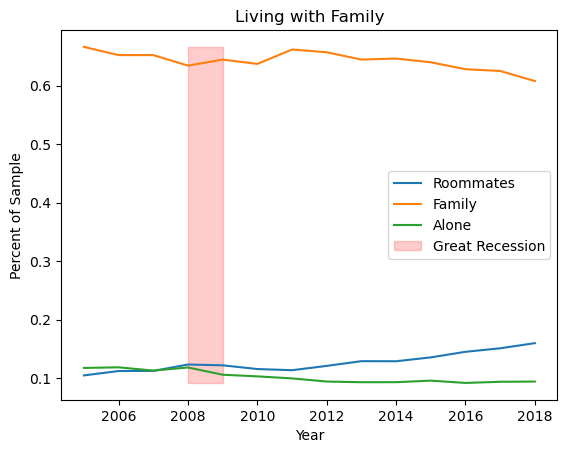

In [65]:
plotTimeline(dfCherlin1, dfCherlin1.columns,'Living with Family')

In [66]:
#Reset temporary dataframe
df = dfNYC.copy()

#Dummy var for child of
df['HHPOSITION'] = mapBool(df, 'HHPOSITION', ['Child','child','Niece','Neph'])

df.head()

YEAR  NUMPREC  STRATA    RENT  ROOMS  BUILTYEAR  BEDROOMS  PERWT  NCHILD  \
0  2005        1   30334   840.0      3          5         2   52.0   False   
1  2005        5   40034   800.0      4          1         3  109.0   False   
2  2005        2   70234  1500.0      6          5         4  146.0   False   
3  2005        2   70234  1500.0      6          5         4  145.0   False   
4  2005        2   90334   930.0      3          5         2   75.0   False   

   FEMALE  AGE  MARRNO  WORKEDYR   INCTOT  POVERTY  COMMUTES  HHPOSITION  \
0   False   22   False         3  28000.0    283.0      True       False   
1   False   19   False         1      0.0      1.0     False       False   
2   False   27   False         3  81000.0    501.0      True       False   
3   False   27   False         3  35000.0    351.0      True       False   
4   False   26   False         3  58000.0    501.0      True       False   

                                  HHDES   ROOMMATES           EDUCATIONLVL  \
0      Female householder, living alone       Alone            High school   
1        HHTYPE could not be determined         NaN  Less than High School   
2  Female householder, not living alone  Non-Family     4 years of college   
3  Female householder, not living alone  Non-Family     4 years of college   
4       Married-couple family household      Family     4 years of college   

   COLLEGEYRS     RCOST  
0           1  0.360000  
1           0       NaN  
2           4  0.111111  
3           4  0.257143  
4           4  0.096207

In [67]:

#18-24
s1824 = includeVal(df,'AGE',[18,19,20,21,22,23,24])
#25-29
s2529 = includeVal(df,'AGE',[25,26,27,28,29])
#30-33
s3033 = includeVal(df,'AGE',[30,31,32,33])

dfCherlin2 = pd.DataFrame(index=dfCherlin1.index)
dfCherlin2['18-24'] = genPercent(s1824, 'HHPOSITION', [True])
dfCherlin2['25-29'] = genPercent(s2529, 'HHPOSITION', [True])
dfCherlin2['30-33'] = genPercent(s3033, 'HHPOSITION', [True])


dfCherlin2.head()


count    14.000000
mean      0.555195
std       0.030076
min       0.511823
25%       0.522943
50%       0.566911
75%       0.580899
max       0.585751
Name: HHPOSITION, dtype: float64
count    14.000000
mean      0.171793
std       0.023625
min       0.138909
25%       0.147687
50%       0.179787
75%       0.190873
max       0.200306
Name: HHPOSITION, dtype: float64
count    14.000000
mean      0.089339
std       0.010283
min       0.073492
25%       0.082237
50%       0.089914
75%       0.098163
max       0.104942
Name: HHPOSITION, dtype: float64


18-24     25-29     30-33
2005  0.511880  0.145527  0.080808
2006  0.511823  0.138909  0.077778
2007  0.519937  0.143913  0.073492
2008  0.515443  0.142807  0.074837
2009  0.531962  0.155150  0.089458

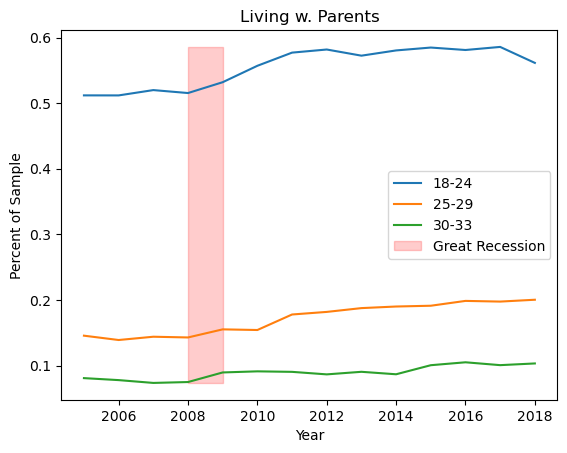

In [68]:
plotTimeline(dfCherlin2, dfCherlin2.columns,'Living w. Parents')

In [69]:
#Refresh
df = dfNYC.copy()
print(df.shape[0])

df['HHPOSITION'] = mapBool(df, 'HHPOSITION', ['Child','child','Niece','Neph'])


235998


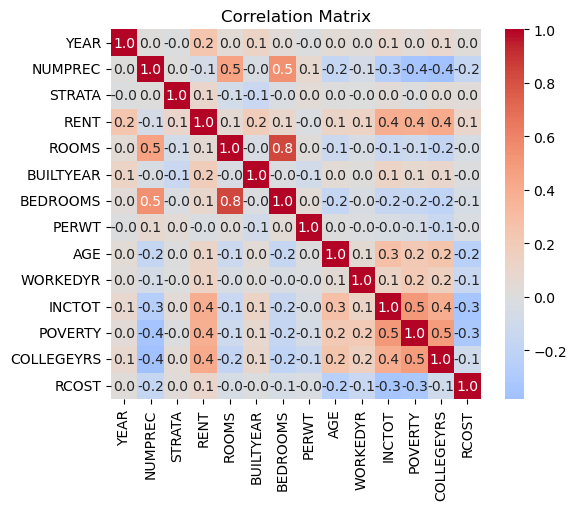

Columns with high correlation: ['BEDROOMS']


/var/folders/pb/3jsdg1n52l722yxt1jl699pw0000gn/T/ipykernel_32620/3555983261.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # select upper triangle of correlation matrix


['BEDROOMS']

In [70]:
detectMulti(df)

In [71]:
df['R_b'] = df['RENT']/df['BEDROOMS']
df['R_r'] = df['RENT']/df['ROOMS']
df['Spread'] = df['R_b'] - df['R_r']
df['Spread'] = df['Spread'].clip(lower=0)
df['Spread'].describe()

count    235998.000000
mean        116.597961
std         131.994779
min           0.000000
25%          20.500000
50%          91.666667
75%         160.000000
max        2466.666667
Name: Spread, dtype: float64

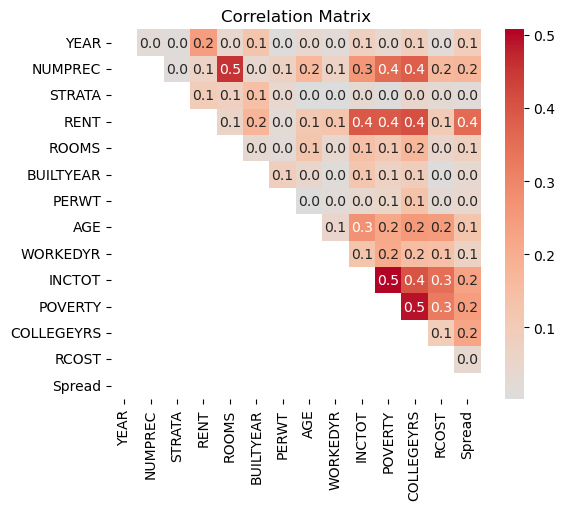

No columns with high correlation found.


[]

In [215]:
dfSpread = df.copy()

dropList = ['R_b','R_r','BEDROOMS']
dfSpread = dfSpread.drop(dropList,axis=1)

detectMulti(dfSpread)

## select for no children, unmarried
boolean for lives with parents or not


In [73]:
df1 = dfSpread.copy()
print(list(df1))

['YEAR', 'NUMPREC', 'STRATA', 'RENT', 'ROOMS', 'BUILTYEAR', 'PERWT', 'NCHILD', 'FEMALE', 'AGE', 'MARRNO', 'WORKEDYR', 'INCTOT', 'POVERTY', 'COMMUTES', 'HHPOSITION', 'HHDES', 'ROOMMATES', 'EDUCATIONLVL', 'COLLEGEYRS', 'RCOST', 'Spread']


In [74]:
#take out all married samples
df1 = excludeVal(df1,'MARRNO',True,'nonsense')
#take out all samples with children
df1 = excludeVal(df1,'NCHILD',True,'nonsense')

#Choose some columns to keep
sliceList = ['YEAR', 'NUMPREC', 'RENT', 'ROOMS', 
             'BUILTYEAR', 'PERWT',
             'FEMALE', 'AGE',
             'WORKEDYR', 'INCTOT', 'POVERTY', 
             'COMMUTES', 'HHPOSITION', 'ROOMMATES', 
             'COLLEGEYRS', 'RCOST', 'Spread']
df1 = df1[sliceList].copy()
df1 = df1.dropna(how='any')
df1.head()


YEAR  NUMPREC    RENT  ROOMS  BUILTYEAR  PERWT  FEMALE  AGE  WORKEDYR  \
0  2005        1   840.0      3          5   52.0   False   22         3   
2  2005        2  1500.0      6          5  146.0   False   27         3   
3  2005        2  1500.0      6          5  145.0   False   27         3   
4  2005        2   930.0      3          5   75.0   False   26         3   
5  2005        2   930.0      3          5   83.0   False   27         3   

    INCTOT  POVERTY  COMMUTES  HHPOSITION   ROOMMATES  COLLEGEYRS     RCOST  \
0  28000.0    283.0      True       False       Alone           1  0.360000   
2  81000.0    501.0      True       False  Non-Family           4  0.111111   
3  35000.0    351.0      True       False  Non-Family           4  0.257143   
4  58000.0    501.0      True       False      Family           4  0.096207   
5  65000.0    501.0      True       False      Family           4  0.085846   

   Spread  
0   140.0  
2   125.0  
3   125.0  
4   155.0  
5   155.0

In [75]:
df1 = oneHot(df1)
df1.head()

FEMALE has been converted to dummy variables and the following columns have been added: FEMALE_False
COMMUTES has been converted to dummy variables and the following columns have been added: COMMUTES_False, COMMUTES_True
HHPOSITION has been converted to dummy variables and the following columns have been added: HHPOSITION_False, HHPOSITION_True
ROOMMATES has been one-hot encoded and the following columns have been added: ROOMMATES_Alone, ROOMMATES_Family, ROOMMATES_Non-Family


YEAR  NUMPREC    RENT  ROOMS  BUILTYEAR  PERWT   AGE  WORKEDYR   INCTOT  \
0  2005.0      1.0   840.0    3.0        5.0   52.0  22.0       3.0  28000.0   
2  2005.0      2.0  1500.0    6.0        5.0  146.0  27.0       3.0  81000.0   
3  2005.0      2.0  1500.0    6.0        5.0  145.0  27.0       3.0  35000.0   
4  2005.0      2.0   930.0    3.0        5.0   75.0  26.0       3.0  58000.0   
5  2005.0      2.0   930.0    3.0        5.0   83.0  27.0       3.0  65000.0   

   POVERTY  COLLEGEYRS     RCOST  Spread  FEMALE_False  COMMUTES_False  \
0    283.0         1.0  0.360000   140.0           1.0             0.0   
2    501.0         4.0  0.111111   125.0           1.0             0.0   
3    351.0         4.0  0.257143   125.0           1.0             0.0   
4    501.0         4.0  0.096207   155.0           1.0             0.0   
5    501.0         4.0  0.085846   155.0           1.0             0.0   

   COMMUTES_True  HHPOSITION_False  HHPOSITION_True  ROOMMATES_Alone  \
0            1.0               1.0              0.0              1.0   
2            1.0               1.0              0.0              0.0   
3            1.0               1.0              0.0              0.0   
4            1.0               1.0              0.0              0.0   
5            1.0               1.0              0.0              0.0   

   ROOMMATES_Family  ROOMMATES_Non-Family  
0               0.0                   0.0  
2               0.0                   1.0  
3               1.0                   0.0  
4               1.0                   0.0  
5               1.0                   0.0

In [76]:
df1['FEMALE'] = dfSpread['FEMALE']

dropList = ['FEMALE_False','COMMUTES_False','HHPOSITION_False','ROOMMATES_Family']
df1 = df1.drop(dropList,axis=1)

#fix names
fixOneHot_dict = {'COMMUTES_True':'COMMUTES',
                  'HHPOSITION_True':'HHPOSITION',
                  'ROOMMATES_Alone':'Alone',
                  'ROOMMATES_Non-Family':'ROOMATES'}


df1 = df1.rename(fixOneHot_dict,axis=1)
list(df1)


['YEAR',
 'NUMPREC',
 'RENT',
 'ROOMS',
 'BUILTYEAR',
 'PERWT',
 'AGE',
 'WORKEDYR',
 'INCTOT',
 'POVERTY',
 'COLLEGEYRS',
 'RCOST',
 'Spread',
 'COMMUTES',
 'HHPOSITION',
 'Alone',
 'ROOMATES',
 'FEMALE']

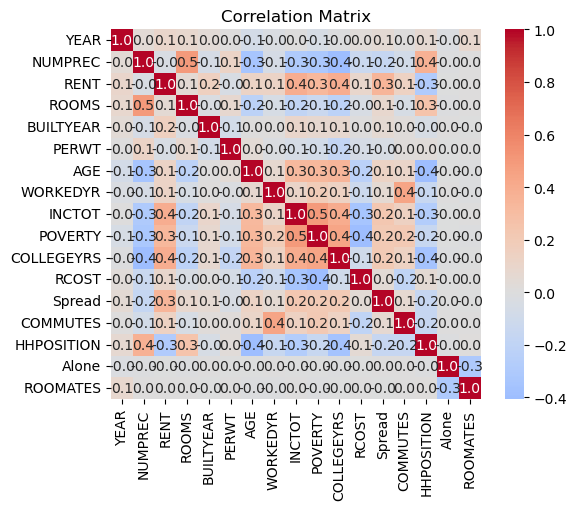

No columns with high correlation found.


/var/folders/pb/3jsdg1n52l722yxt1jl699pw0000gn/T/ipykernel_32620/3555983261.py:24: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) # select upper triangle of correlation matrix


[]

In [77]:
detectMulti(df1)

In [78]:
len(list(df1))

18

In [79]:
pcaTable(df1,3)

Explained Variance Ratio:
[0.22263993 0.10252956 0.08700107]
[[-0.00878715 -0.32501965  0.23027237 -0.20293668  0.05035817 -0.06773369
   0.34838959  0.1633748   0.37992527  0.38185539  0.3994097  -0.16472777
   0.17192647  0.20665766 -0.30941757  0.00200054 -0.00751633  0.        ]
 [-0.0124239  -0.43577019 -0.07022987 -0.37884752  0.01446285 -0.14961773
   0.09065205 -0.32815161 -0.10740295 -0.20930745  0.11187475  0.48144518
  -0.00905012 -0.43662177 -0.18028012  0.008244   -0.00752322  0.        ]
 [ 0.0315881   0.02964941  0.09256911  0.07386221  0.01450841 -0.02213641
  -0.02893948 -0.06899624  0.04348839  0.02146034  0.04897684  0.03215115
   0.0745694  -0.0668175   0.02829101 -0.70535588  0.68092824 -0.        ]]
\begin{tabular}{rrrrrrrrrrrrrrrrrrr}
\toprule
    &        YEAR &    NUMPREC &       RENT &      ROOMS &   BUILTYEAR &      PERWT &        AGE &   WORKEDYR &     INCTOT &    POVERTY &   COLLEGEYRS &      RCOST &      Spread &   COMMUTES &   HHPOSITION &       Alone &  

## Visualization using PCA with few components will not generate enough explained variance. 
Explained Variance Ratio:
[0.22263991 0.10253148]
[[-0.00878674 -0.32506414  0.23023124 -0.20286007  0.05041084 -0.06773289
   0.3483903   0.16336881  0.37990221  0.38185794  0.39943011 -0.16473594
   0.17191141  0.20666126 -0.30944606  0.00200633 -0.00751519  0.        ]
 [-0.01233676 -0.43680745 -0.07038843 -0.37754553  0.01309879 -0.14923669
   0.08990636 -0.32987528 -0.10723105 -0.20917201  0.11349436  0.4821319
  -0.01024849 -0.43489102 -0.1796193   0.0079844  -0.00788914  0.        ]]
\begin{tabular}{rrrrrrrrrrrrrrrrrrr}
\toprule
    &        YEAR &   NUMPREC &       RENT &     ROOMS &   BUILTYEAR &      PERWT &       AGE &   WORKEDYR &    INCTOT &   POVERTY &   COLLEGEYRS &     RCOST &     Spread &   COMMUTES &   HHPOSITION &      Alone &    ROOMATES &   FEMALE \\
\midrule
  0 & -0.00878674 & -0.325064 &  0.230231  & -0.20286  &   0.0504108 & -0.0677329 & 0.34839   &   0.163369 &  0.379902 &  0.381858 &     0.39943  & -0.164736 &  0.171911  &   0.206661 &    -0.309446 & 0.00200633 & -0.00751519 &        0 \\
  1 & -0.0123368  & -0.436807 & -0.0703884 & -0.377546 &   0.0130988 & -0.149237  & 0.0899064 &  -0.329875 & -0.107231 & -0.209172 &     0.113494 &  0.482132 & -0.0102485 &  -0.434891 &    -0.179619 & 0.0079844  & -0.00788914 &        0 \\
\bottomrule
\end{tabular}

#### For PCA 4
Explained Variance Ratio:
[0.22263993 0.10253165 0.08700263]

In [230]:
print(list(df1))

['YEAR', 'NUMPREC', 'RENT', 'ROOMS', 'BUILTYEAR', 'PERWT', 'AGE', 'WORKEDYR', 'INCTOT', 'POVERTY', 'COLLEGEYRS', 'RCOST', 'Spread', 'COMMUTES', 'HHPOSITION', 'Alone', 'ROOMATES', 'FEMALE']


In [80]:
#Too big for clustering. Select list

selectList = ['YEAR','BUILTYEAR','AGE','WORKEDYR','POVERTY','COLLEGEYRS','Spread','HHPOSITION','COMMUTES']
dfSelect = df1[selectList]

In [81]:
print(dfSelect.dtypes)
dfSelect.describe()

YEAR          float64
BUILTYEAR     float64
AGE           float64
WORKEDYR      float64
POVERTY       float64
COLLEGEYRS    float64
Spread        float64
HHPOSITION    float64
COMMUTES      float64
dtype: object


YEAR     BUILTYEAR           AGE      WORKEDYR       POVERTY  \
count  85871.000000  85871.000000  85871.000000  85871.000000  85871.000000   
mean    2011.462461      3.565336     25.937849      2.930198    329.875767   
std        4.131258      3.161893      3.930610      0.348909    149.235842   
min     2005.000000      1.000000     18.000000      1.000000      1.000000   
25%     2008.000000      1.000000     23.000000      3.000000    199.000000   
50%     2011.000000      3.000000     26.000000      3.000000    339.000000   
75%     2015.000000      5.000000     29.000000      3.000000    501.000000   
max     2018.000000     22.000000     33.000000      3.000000    501.000000   

         COLLEGEYRS        Spread    HHPOSITION      COMMUTES  
count  85871.000000  85871.000000  85871.000000  85871.000000  
mean       2.250853    114.904836      0.323194      0.852849  
std        1.972477    135.401481      0.467699      0.354258  
min        0.000000      0.000000      0.000000      0.000000  
25%        0.000000     15.416667      0.000000      1.000000  
50%        2.000000     90.000000      0.000000      1.000000  
75%        4.000000    160.000000      1.000000      1.000000  
max        5.000000   2466.666667      1.000000      1.000000

In [82]:
type(dfSelect)

pandas.core.frame.DataFrame

In [83]:
dfSelect = cleanInvalid(dfSelect)

/var/folders/pb/3jsdg1n52l722yxt1jl699pw0000gn/T/ipykernel_32620/1337767309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


['YEAR', 'BUILTYEAR', 'AGE', 'WORKEDYR', 'POVERTY', 'COLLEGEYRS', 'Spread', 'HHPOSITION', 'COMMUTES']


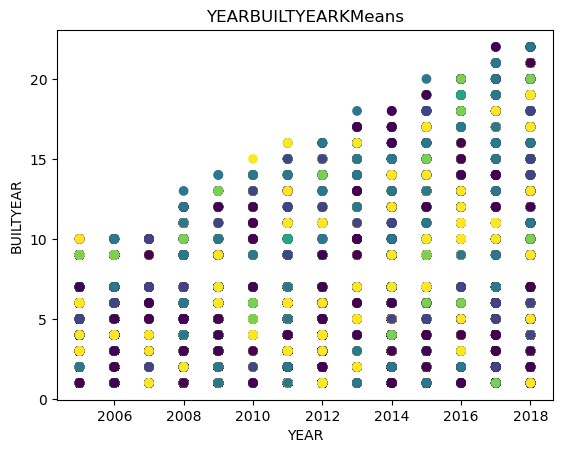

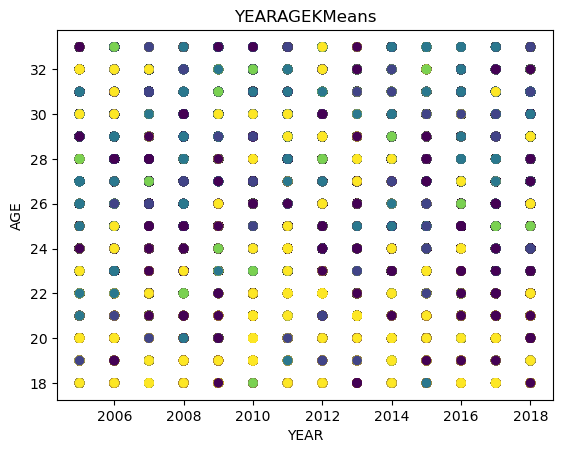

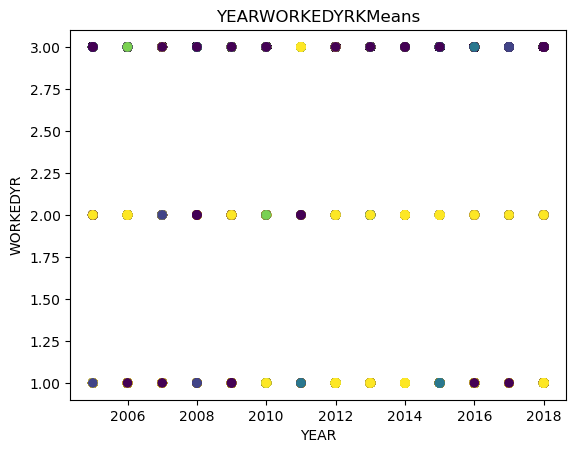

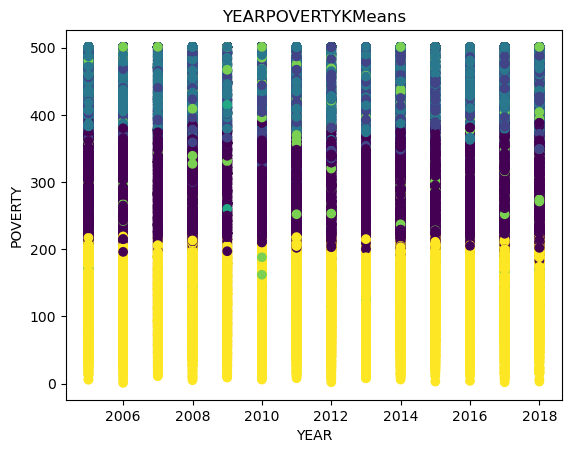

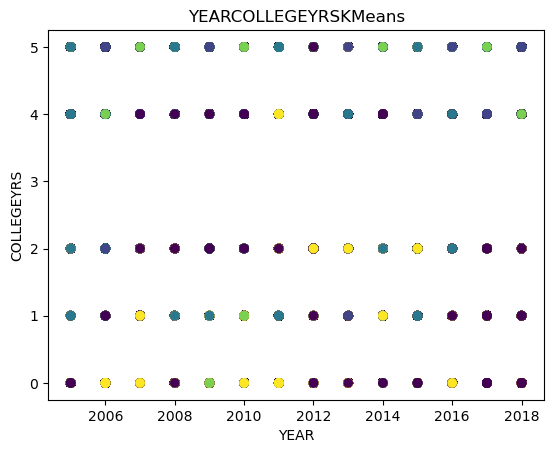

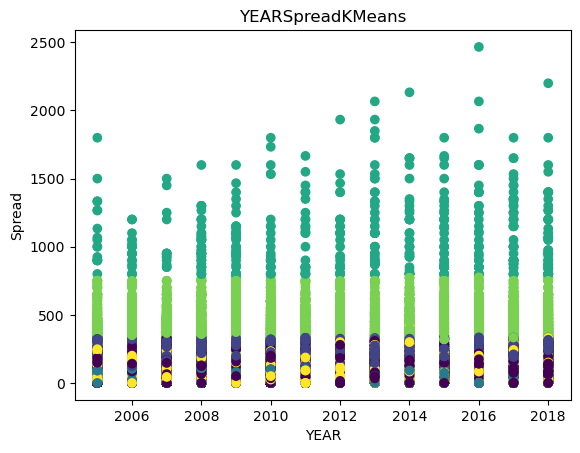

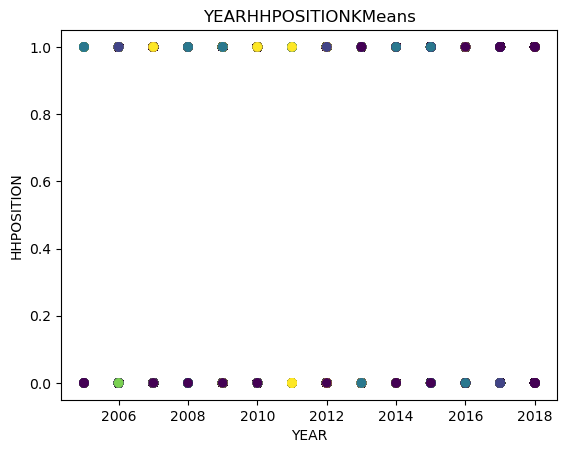

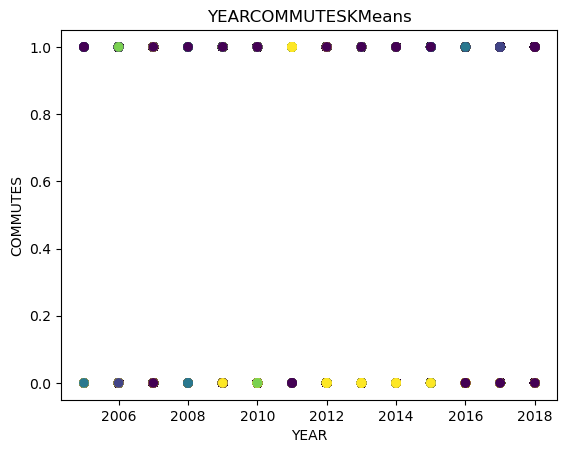

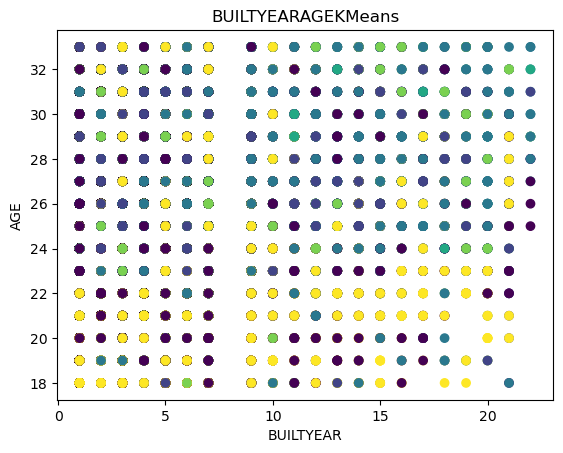

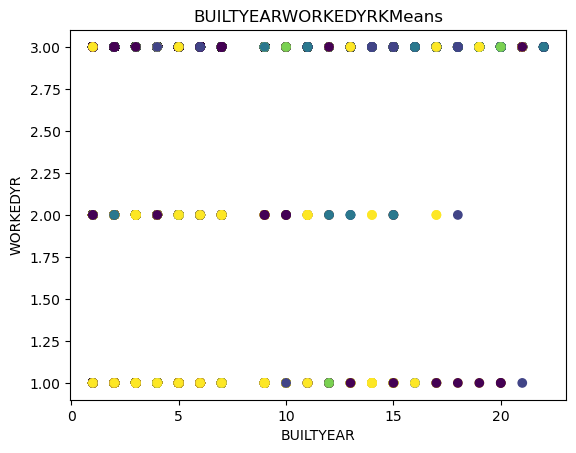

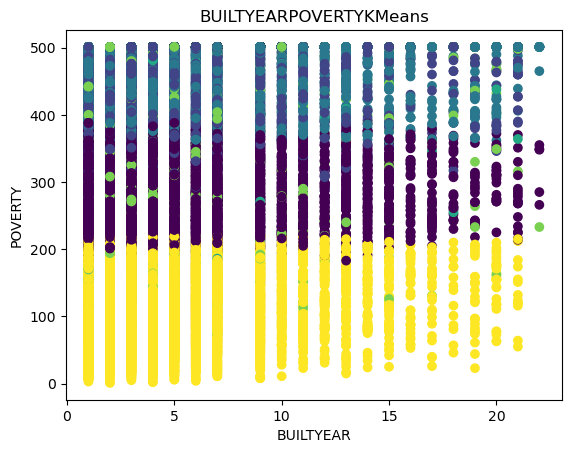

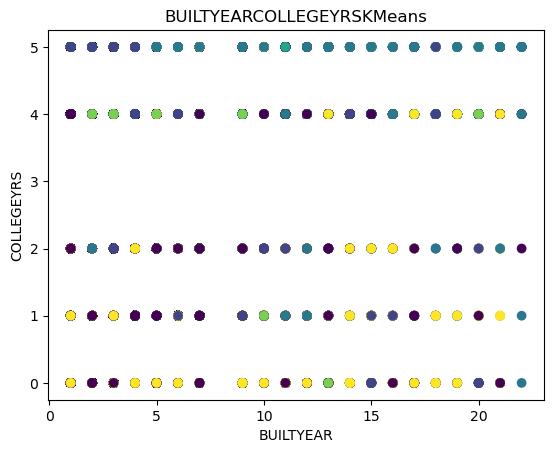

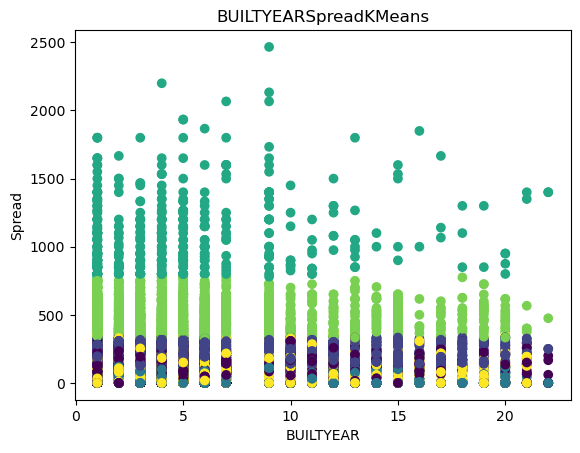

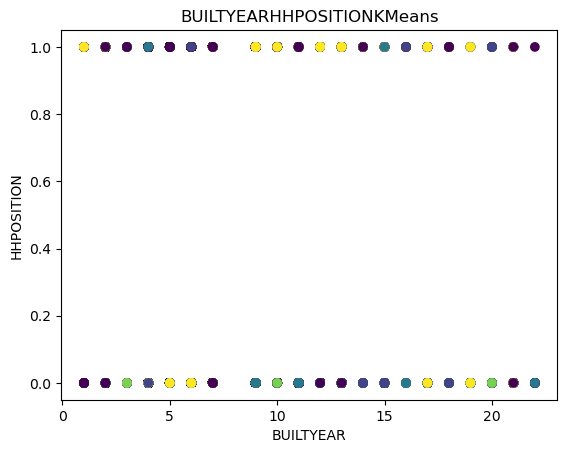

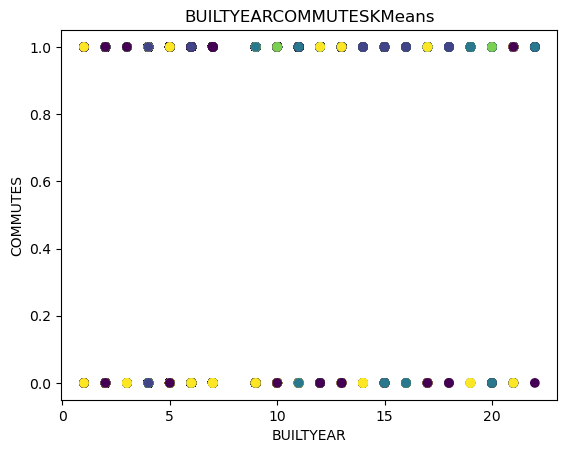

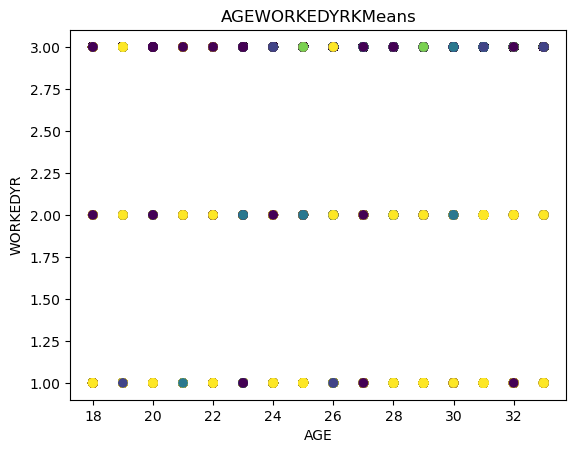

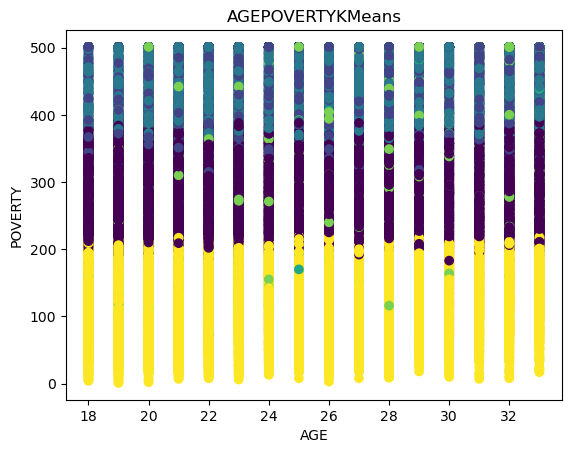

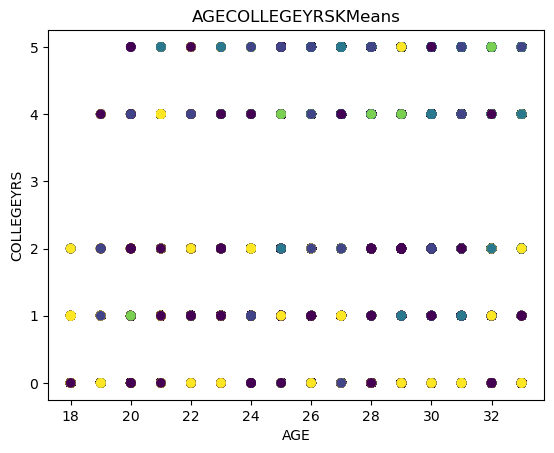

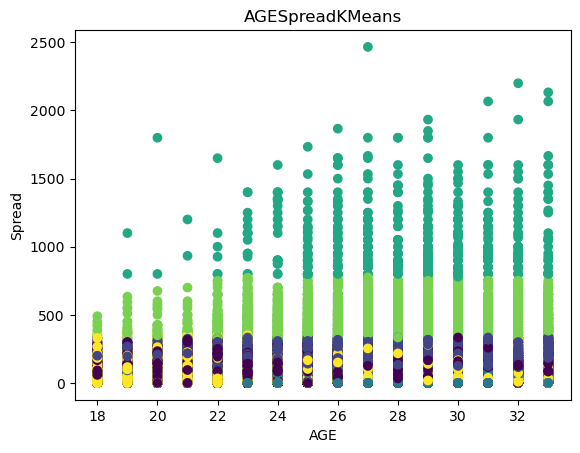

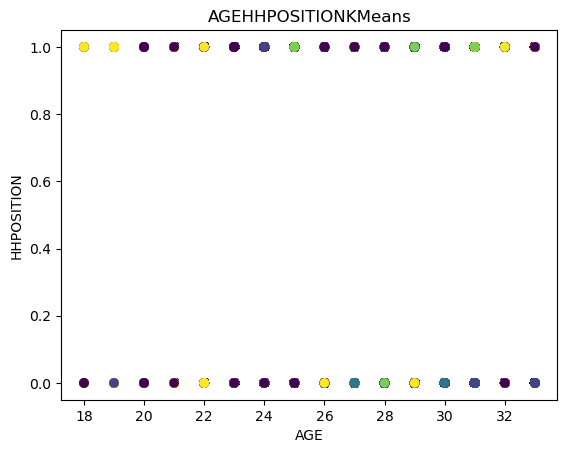

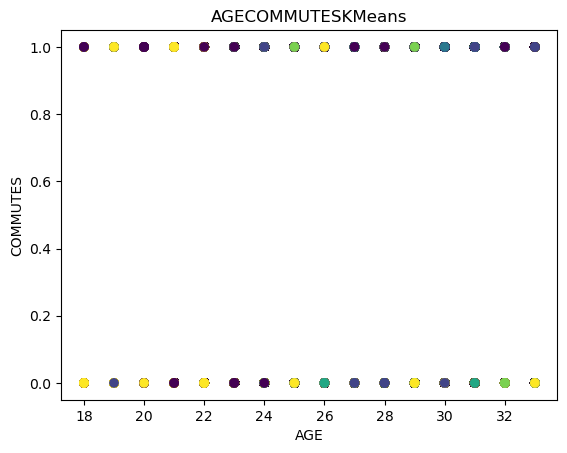

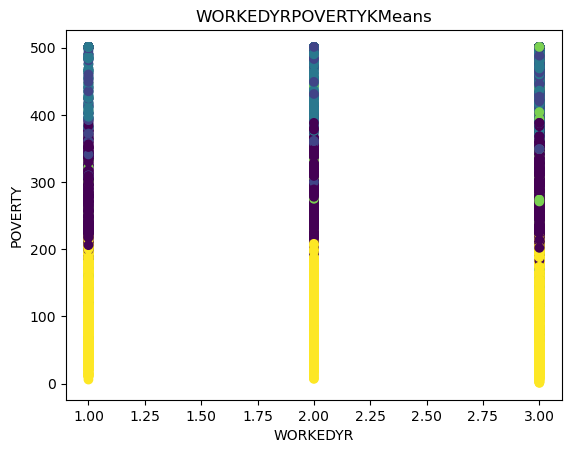

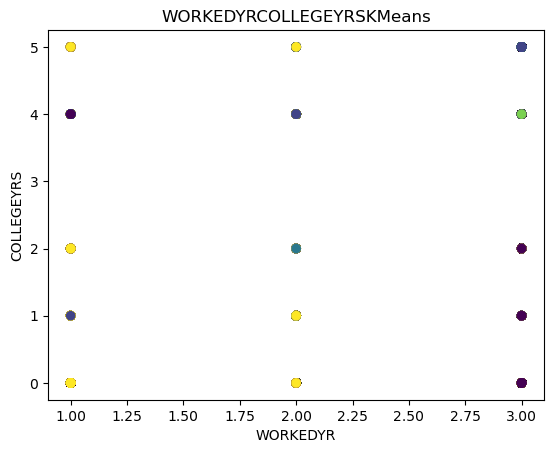

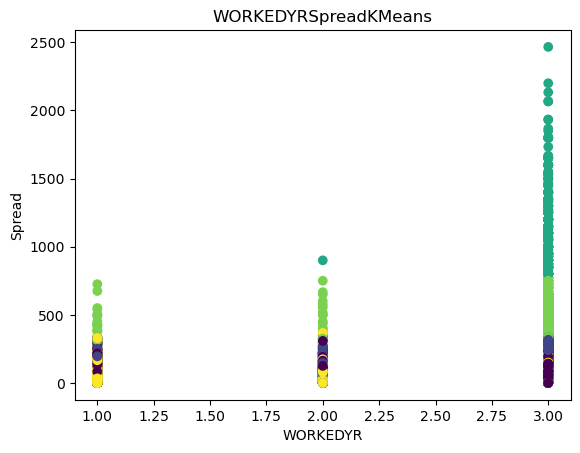

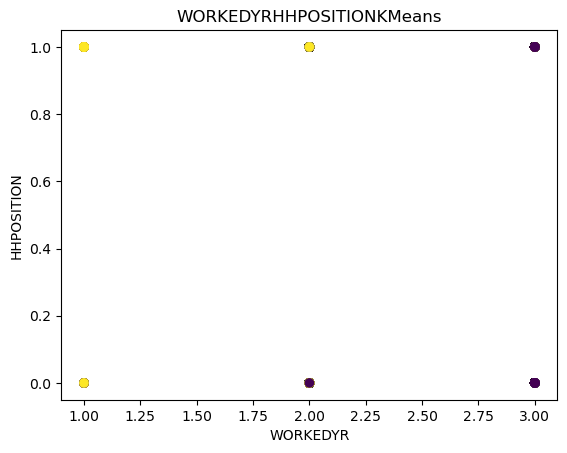

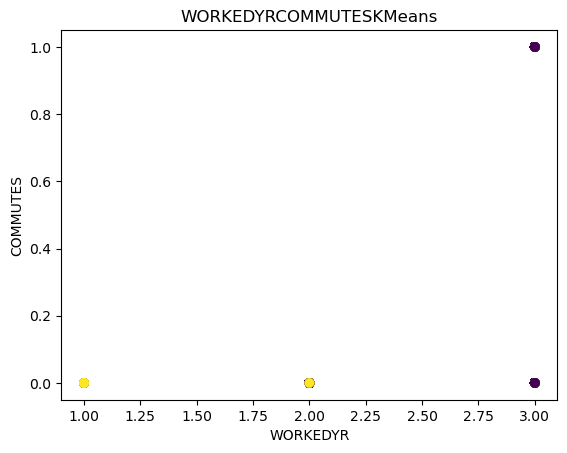

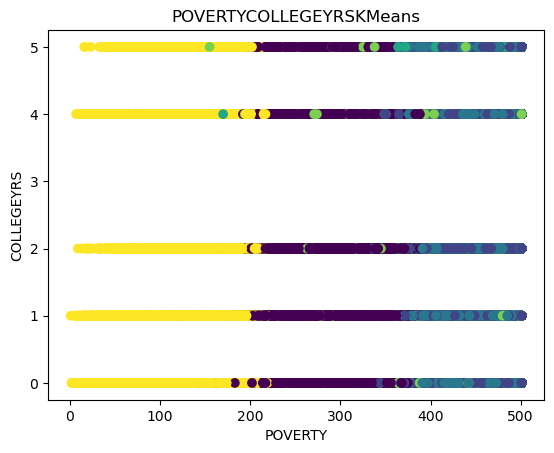

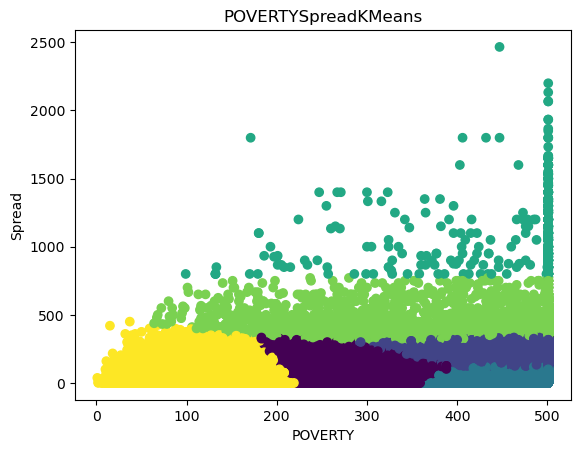

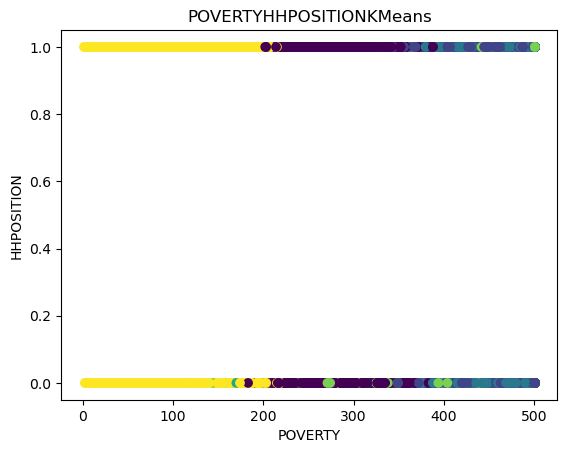

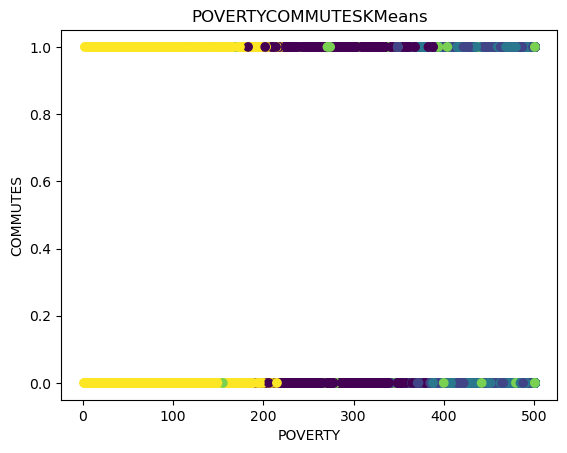

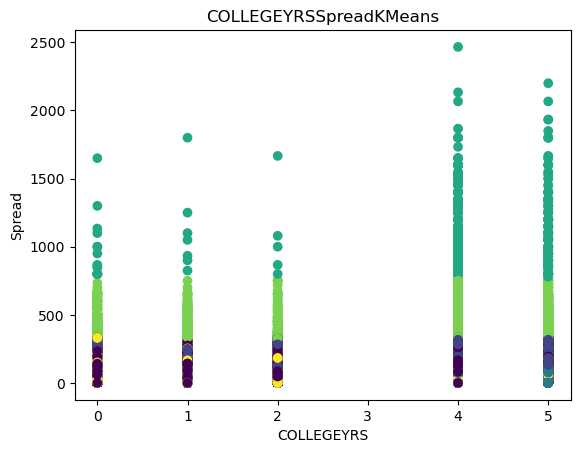

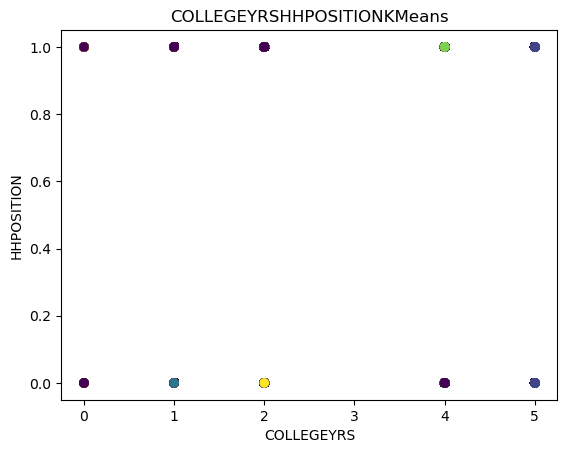

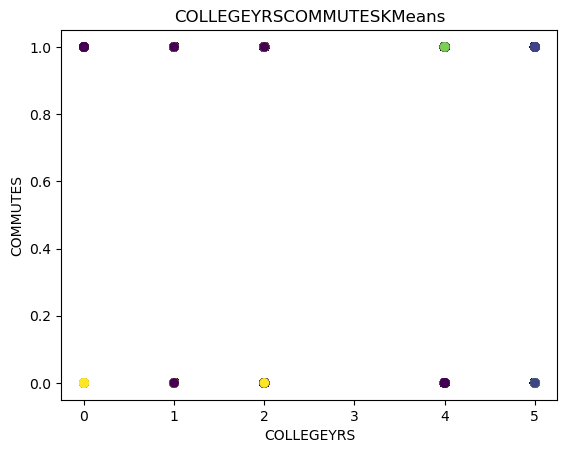

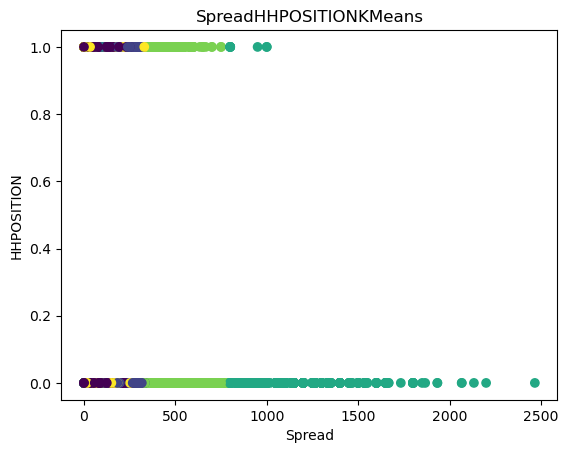

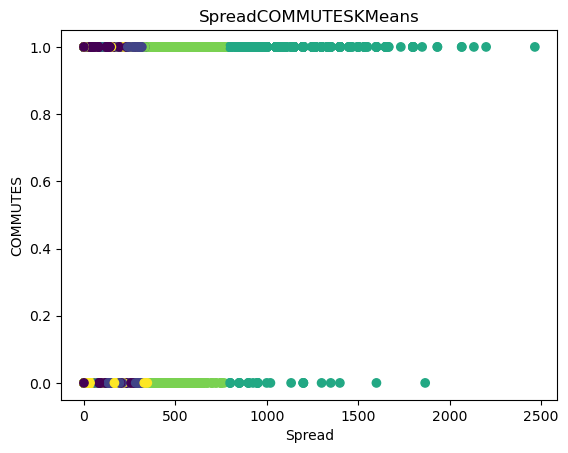

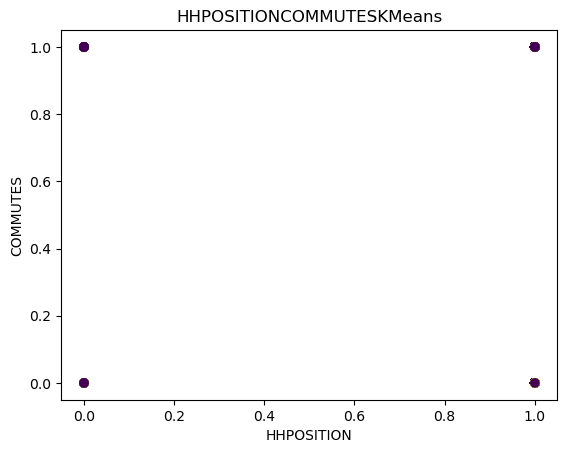

In [84]:
kmean(dfSelect, 6)

In [85]:
dfSelect_n = normDf(dfSelect)

['YEAR', 'BUILTYEAR', 'AGE', 'WORKEDYR', 'POVERTY', 'COLLEGEYRS', 'Spread', 'HHPOSITION', 'COMMUTES', 'KMLABEL']


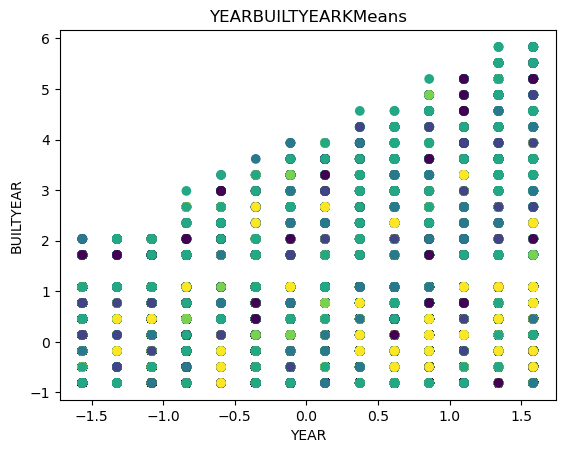

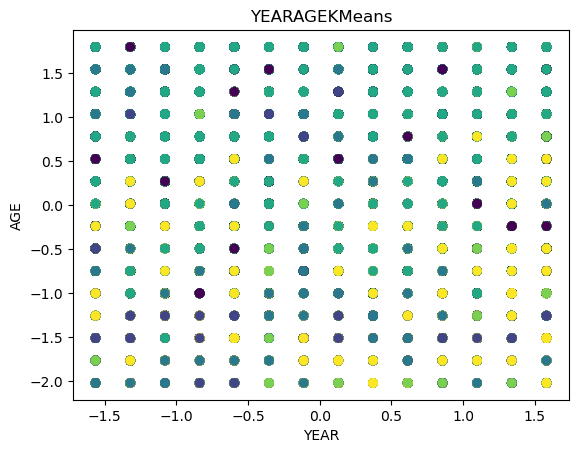

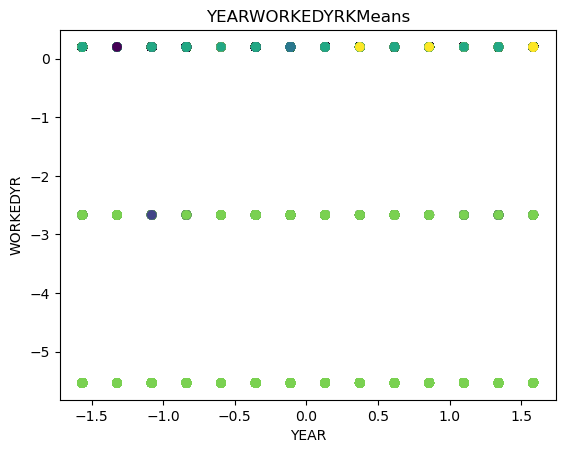

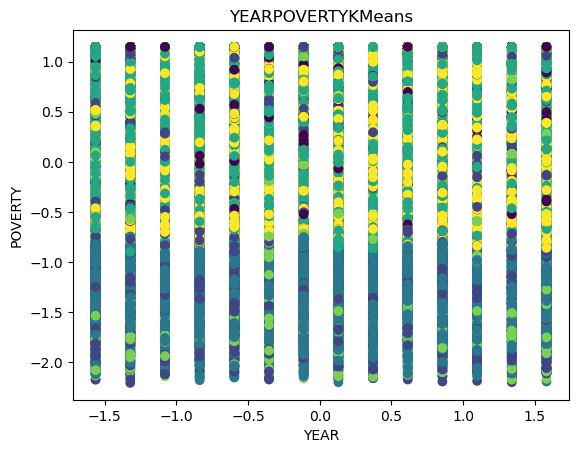

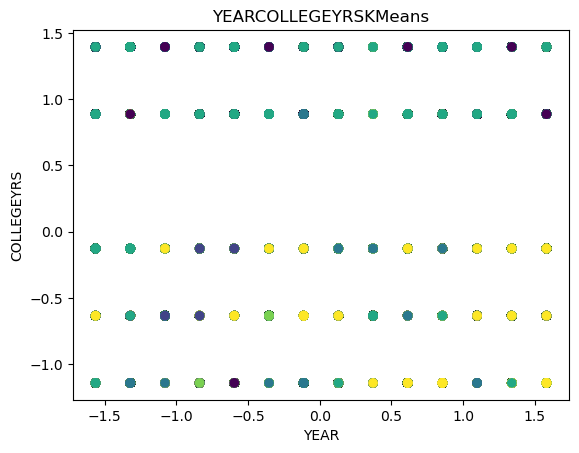

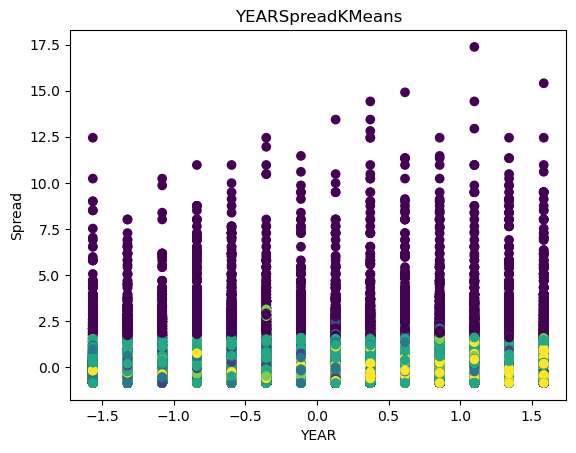

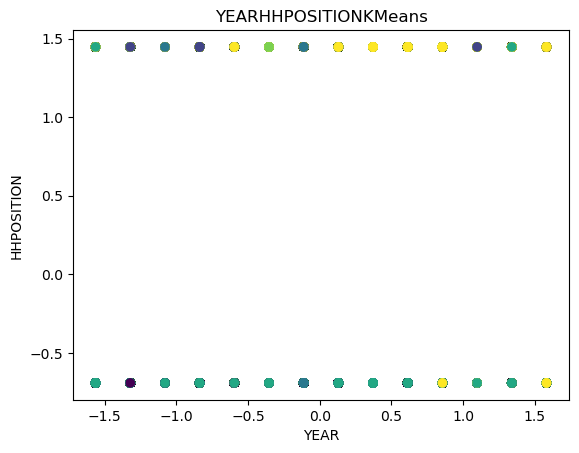

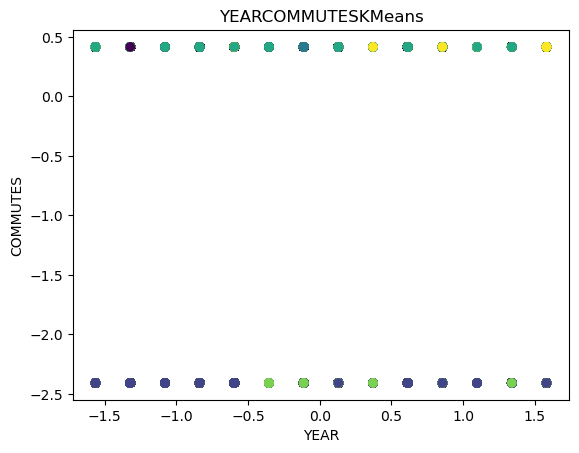

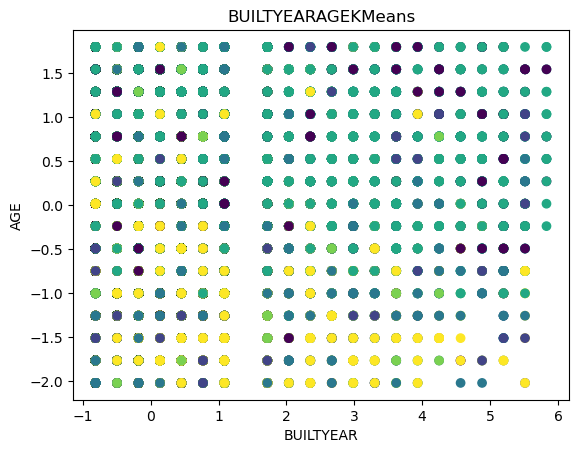

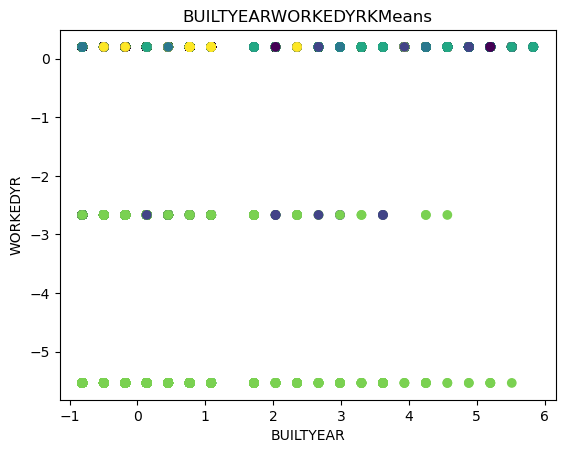

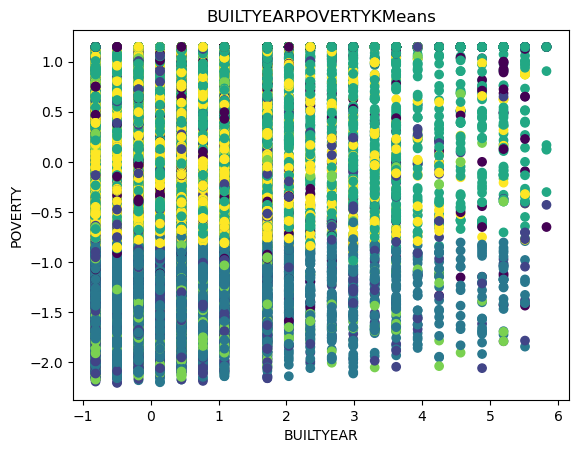

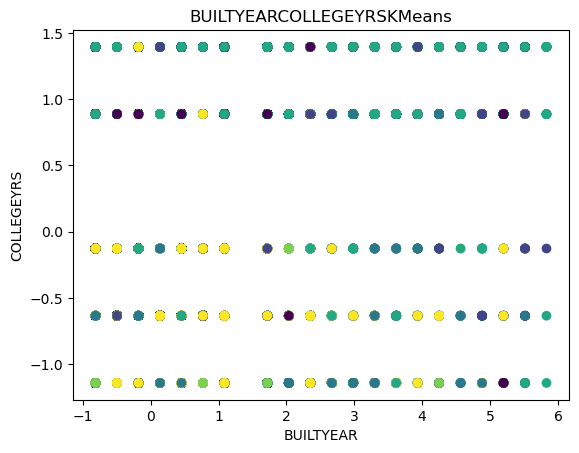

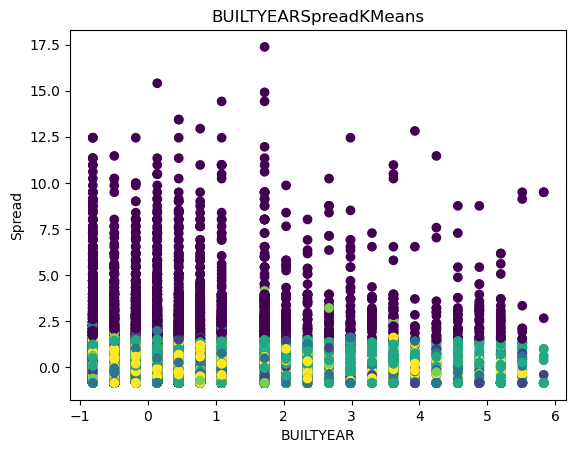

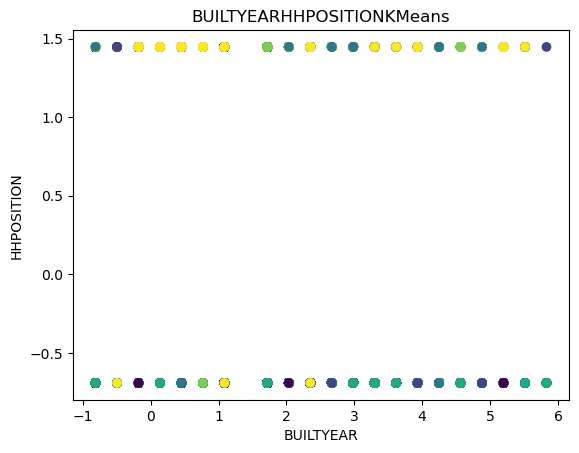

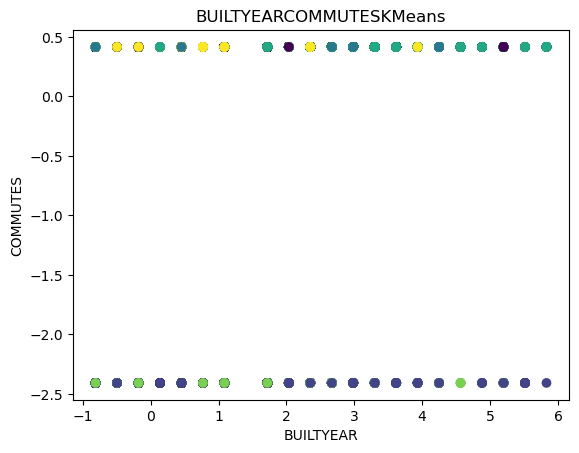

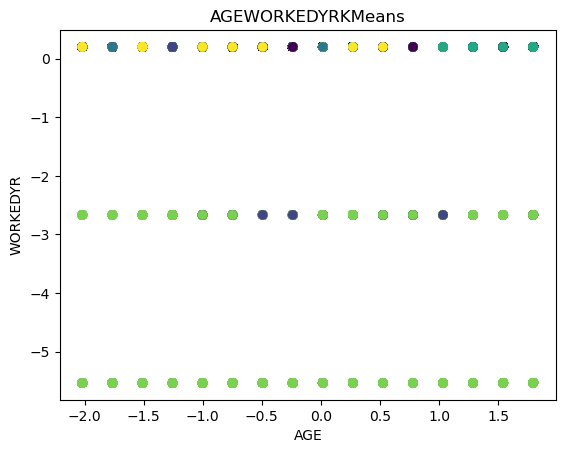

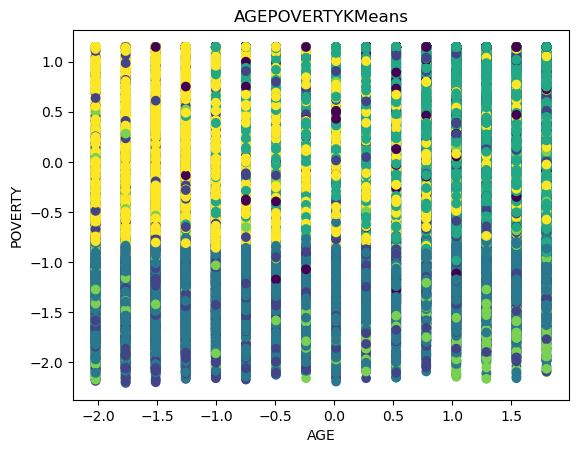

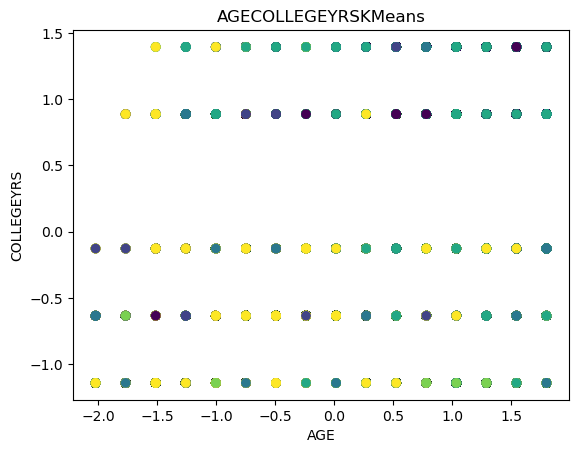

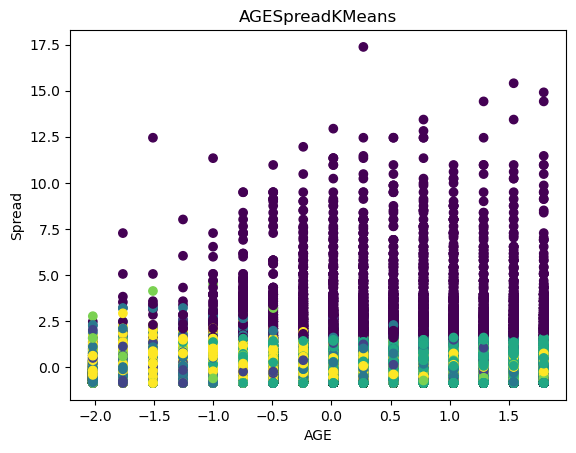

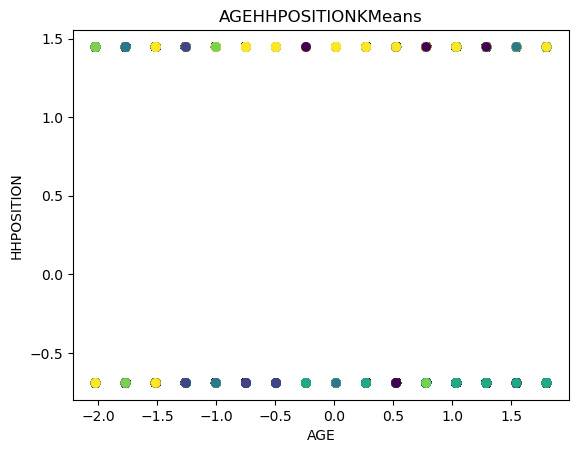

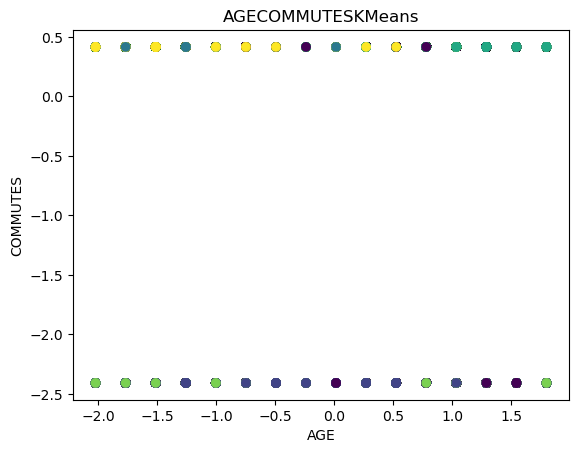

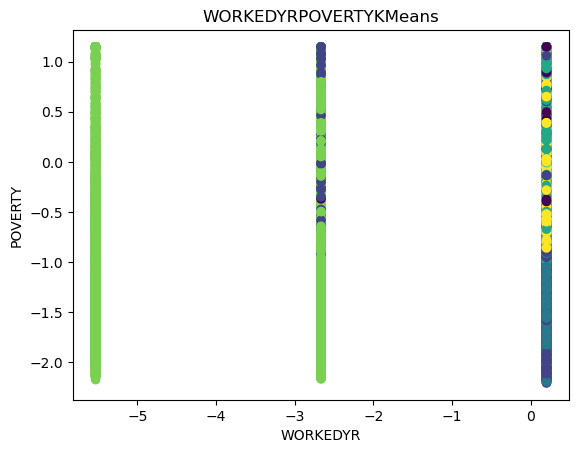

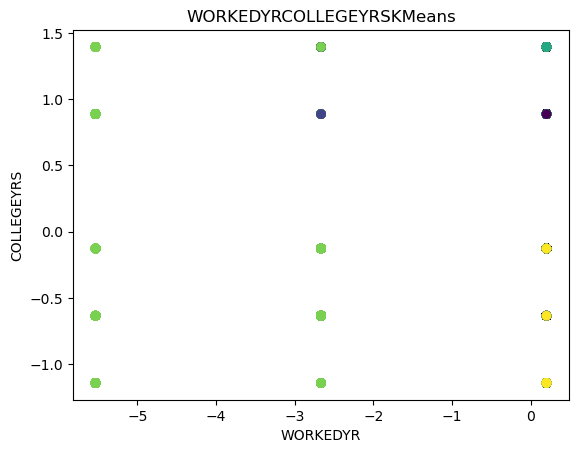

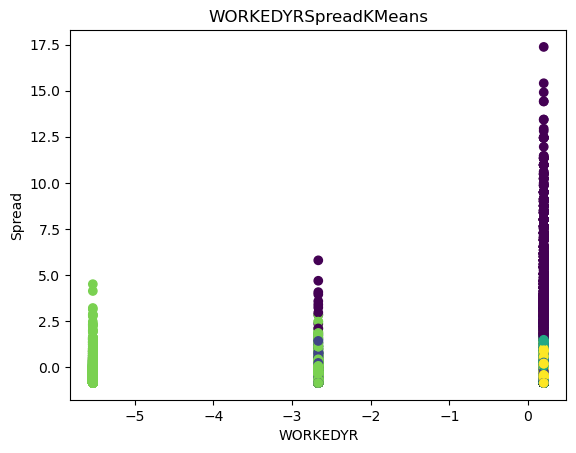

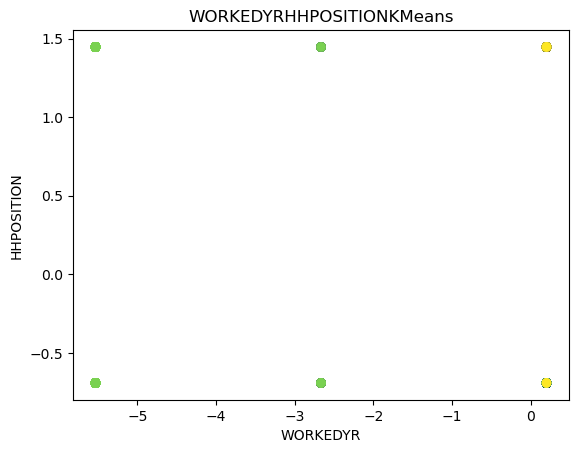

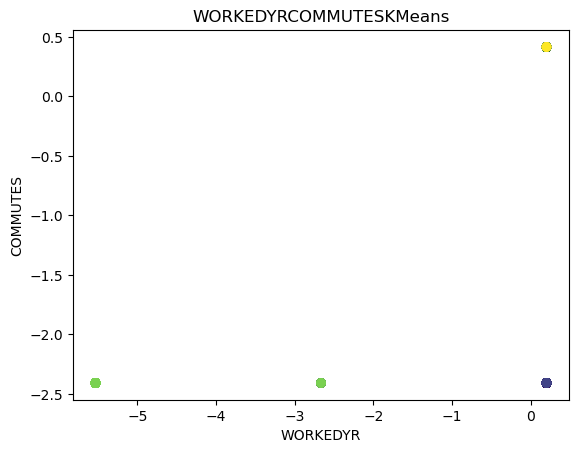

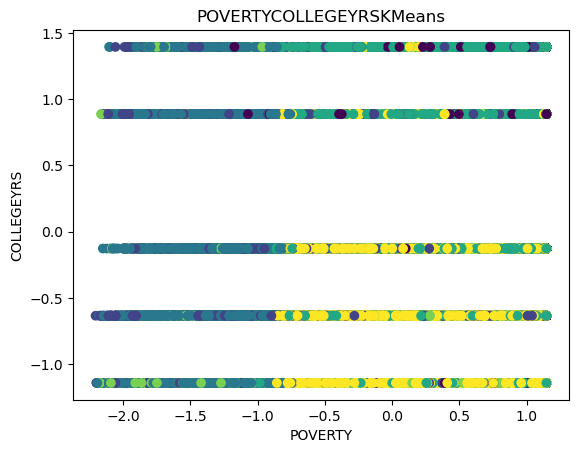

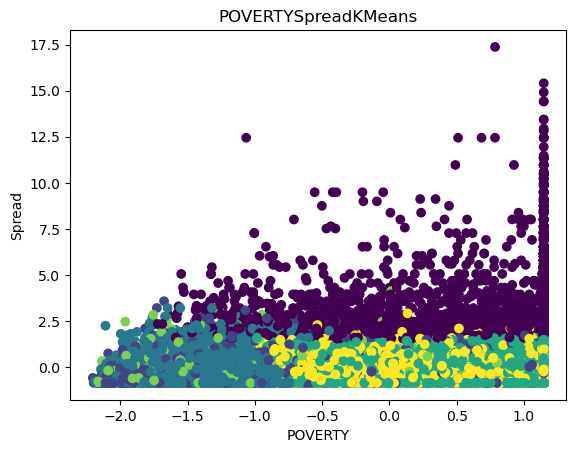

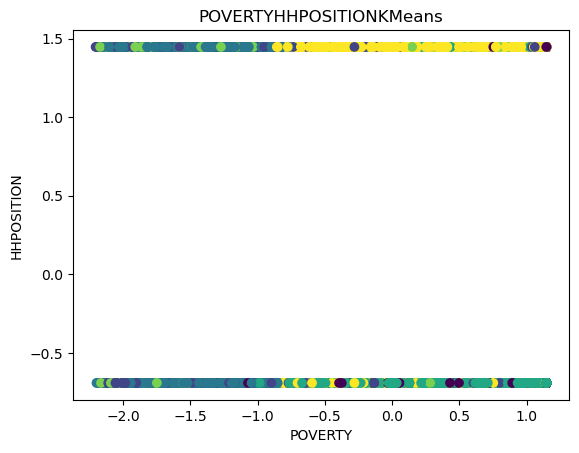

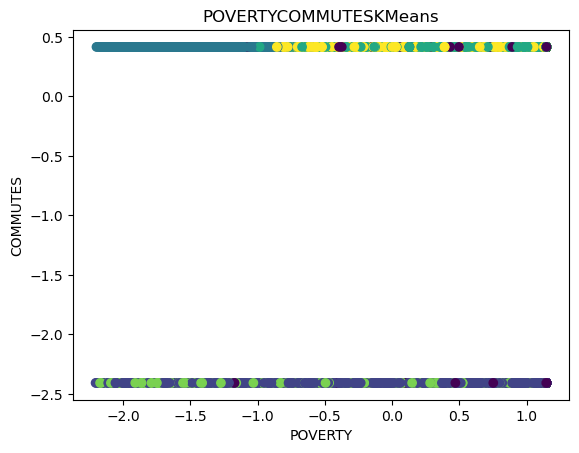

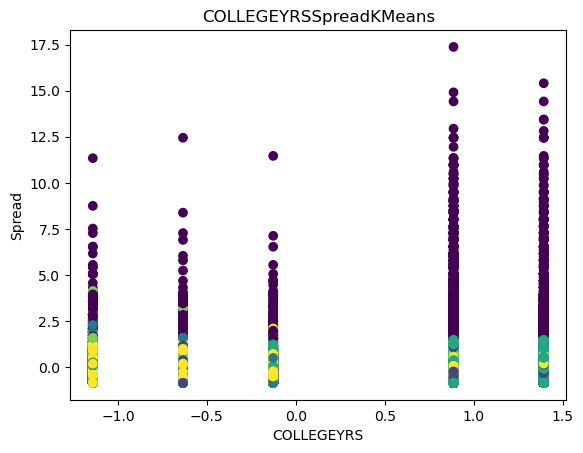

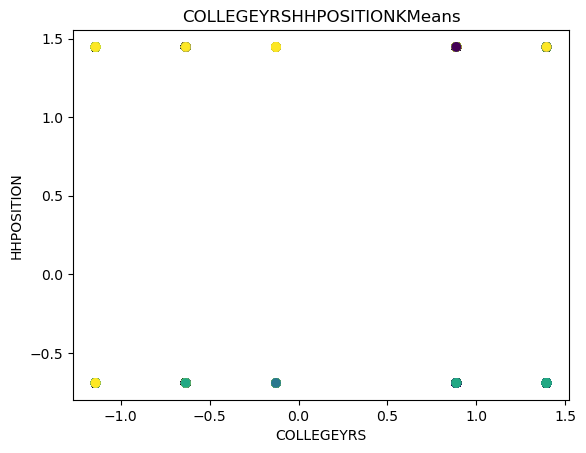

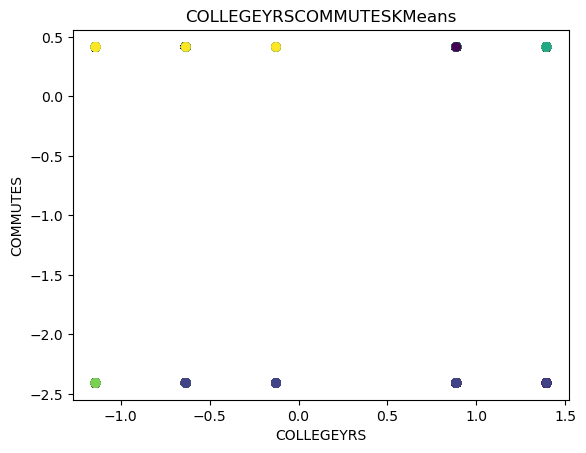

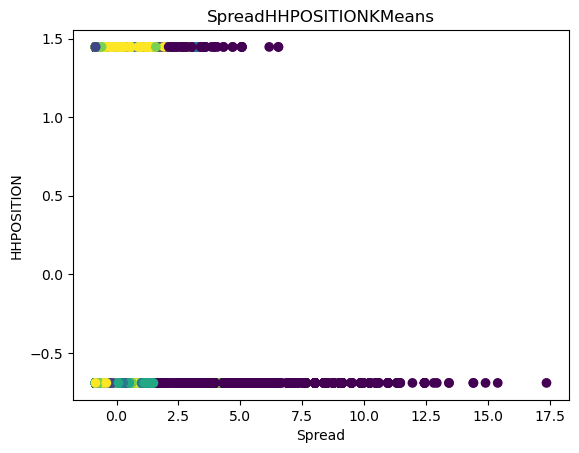

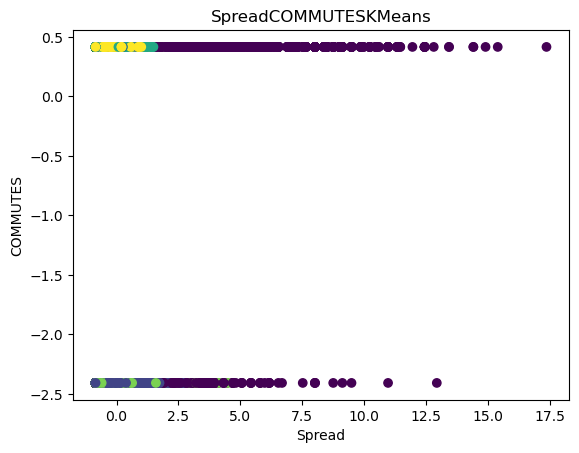

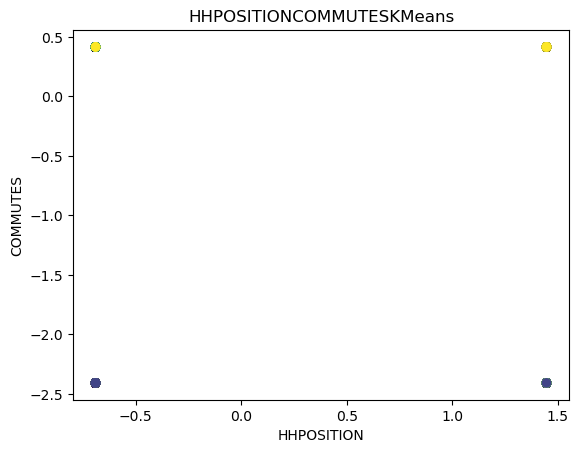

In [86]:
#normalized kmeans
kmean(dfSelect_n, 6)

## FRED prediction of Roommates, Family, Alone

In [202]:
#drop high correlation with rest of FRED
#drop INEQ, missing values
dfFredY = dfFred.copy()
dfFredY = dfFredY.drop(['YIELD'],axis=1)


dfJoin = dfFredY.copy()
#dfJoin = dfFred.copy()

dfParentsFred = joinDfs([dfJoin,dfCherlin2])


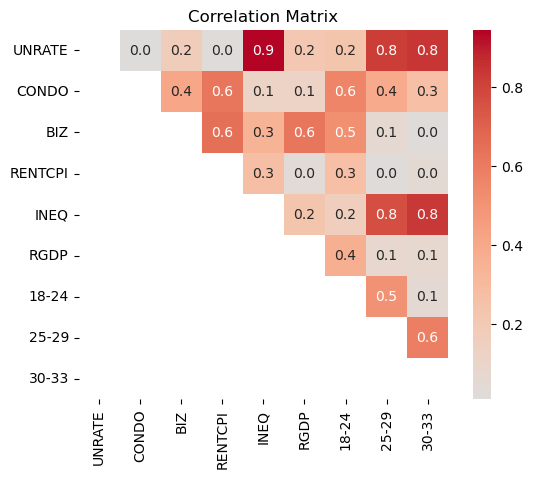

Columns with high correlation: ['INEQ', '25-29', '30-33']


['INEQ', '25-29', '30-33']

In [216]:
detectMulti(dfParentsFred)

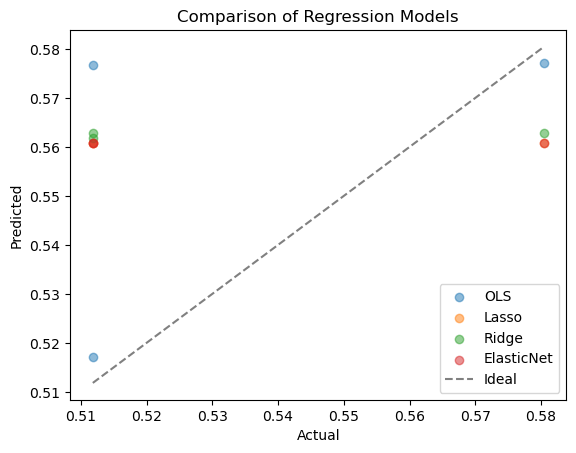

Regression coefficients:
                OLS  Lasso     Ridge  ElasticNet
UNRATE   -0.001995    0.0  0.001720         0.0
CONDO     4.220641    0.0  0.000815         0.0
BIZ      -0.001120    0.0  0.000362         0.0
RENTCPI -17.454370   -0.0 -0.000102        -0.0
RGDP      1.345177    0.0  0.000548         0.0

Test accuracy:
             Train R2   Test R2 Test RMSE
OLS         0.874615  -0.35682  0.037643
Lasso           -0.0 -0.651296  0.041528
Ridge       0.027239 -0.723467  0.042425
ElasticNet      -0.0 -0.651296  0.041528


In [91]:
dfTemp = dfParentsFred.copy()
dfTemp = dfTemp.drop(['25-29', '30-33'],axis=1)
dfTemp = dfTemp.dropna(how='any')
compareReg(dfTemp, '18-24')

### Test Ipums Regressions

In [164]:
dfSpread.head()
dfTemp = df1.copy()
dfTemp = dfTemp.dropna(how='any')
print(list(dfTemp))
dfTemp.head()

['YEAR', 'NUMPREC', 'RENT', 'ROOMS', 'BUILTYEAR', 'PERWT', 'AGE', 'WORKEDYR', 'INCTOT', 'POVERTY', 'COLLEGEYRS', 'RCOST', 'Spread', 'COMMUTES', 'HHPOSITION', 'Alone', 'ROOMATES', 'FEMALE']


YEAR  NUMPREC    RENT  ROOMS  BUILTYEAR  PERWT   AGE  WORKEDYR   INCTOT  \
0  2005.0      1.0   840.0    3.0        5.0   52.0  22.0       3.0  28000.0   
2  2005.0      2.0  1500.0    6.0        5.0  146.0  27.0       3.0  81000.0   
3  2005.0      2.0  1500.0    6.0        5.0  145.0  27.0       3.0  35000.0   
4  2005.0      2.0   930.0    3.0        5.0   75.0  26.0       3.0  58000.0   
5  2005.0      2.0   930.0    3.0        5.0   83.0  27.0       3.0  65000.0   

   POVERTY  COLLEGEYRS     RCOST  Spread  COMMUTES  HHPOSITION  Alone  \
0    283.0         1.0  0.360000   140.0       1.0         0.0    1.0   
2    501.0         4.0  0.111111   125.0       1.0         0.0    0.0   
3    351.0         4.0  0.257143   125.0       1.0         0.0    0.0   
4    501.0         4.0  0.096207   155.0       1.0         0.0    0.0   
5    501.0         4.0  0.085846   155.0       1.0         0.0    0.0   

   ROOMATES  FEMALE  
0       0.0   False  
2       1.0   False  
3       0.0   False  
4       0.0   False  
5       0.0   False

In [137]:
dfTemp_clean = cleanInvalid(dfTemp)
dropList = ['YEAR','NUMPREC','ROOMS','BUILTYEAR','Alone','ROOMATES','RENT']
dfTemp_clean = dfTemp_clean.drop(dropList,axis=1)



Feature importances:
INCTOT        0.214326
POVERTY       0.164840
RCOST         0.155475
AGE           0.138366
PERWT         0.124874
Spread        0.114059
COLLEGEYRS    0.066941
COMMUTES      0.012174
WORKEDYR      0.008944
FEMALE        0.000000
dtype: float64

In-sample accuracy: 0.9998
Out-of-sample accuracy: 0.8233
Mean absolute error: 0.1590
Mean squared error: 0.1590
Root mean squared error: 0.3988
F1 score: 0.7091


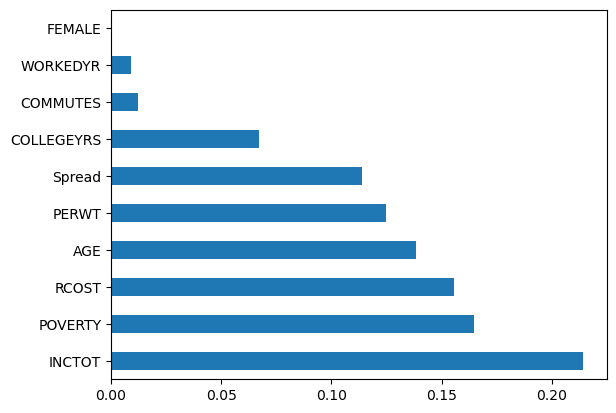

RandomForestClassifier(max_features='sqrt', n_estimators=50)

In [199]:
run_random_forest(dfTemp_clean,'PERWT','HHPOSITION')

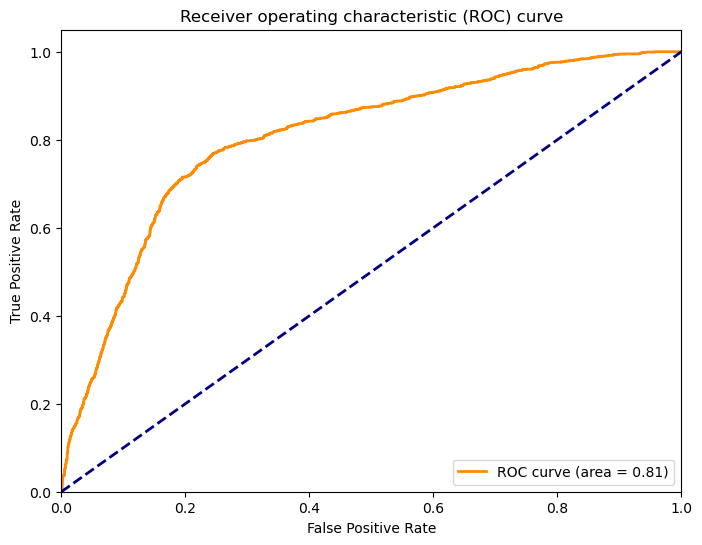

Accuracy: 0.757304099790718
Coefficients:
AGE: -0.026089896800500736
WORKEDYR: -0.0014715217496399974
INCTOT: -7.871495775337225e-05
POVERTY: 0.006720977601456963
COLLEGEYRS: -0.004535687870617395
RCOST: -0.0007501726762180642
Spread: -0.0025096261984071293
COMMUTES: -0.000840800962790336
FEMALE: 0.0
              precision    recall  f1-score   support

         0.0       0.79      0.93      0.85      4906
         1.0       0.69      0.39      0.50      1993

    accuracy                           0.77      6899
   macro avg       0.74      0.66      0.68      6899
weighted avg       0.76      0.77      0.75      6899



In [138]:
logReg(dfTemp_clean, 'HHPOSITION','PERWT',penalty='12',C=1.0)

In [144]:
dfTempDict = dfDict(dfTemp, Fred_dict)
dfTempDict.head()

YEAR  NUMPREC    RENT  ROOMS  BUILTYEAR  PERWT   AGE  WORKEDYR   INCTOT  \
0  2005.0      1.0   840.0    3.0        5.0   52.0  22.0       3.0  28000.0   
2  2005.0      2.0  1500.0    6.0        5.0  146.0  27.0       3.0  81000.0   
3  2005.0      2.0  1500.0    6.0        5.0  145.0  27.0       3.0  35000.0   
4  2005.0      2.0   930.0    3.0        5.0   75.0  26.0       3.0  58000.0   
5  2005.0      2.0   930.0    3.0        5.0   83.0  27.0       3.0  65000.0   

   POVERTY  COLLEGEYRS     RCOST  Spread  COMMUTES  HHPOSITION  Alone  \
0    283.0         1.0  0.360000   140.0       1.0         0.0    1.0   
2    501.0         4.0  0.111111   125.0       1.0         0.0    0.0   
3    351.0         4.0  0.257143   125.0       1.0         0.0    0.0   
4    501.0         4.0  0.096207   155.0       1.0         0.0    0.0   
5    501.0         4.0  0.085846   155.0       1.0         0.0    0.0   

   ROOMATES  FEMALE    UNRATE     CONDO        BIZ   RENTCPI  INEQ      RGDP  \
0       0.0   False  4.958333  0.013379  15.466666  0.004356   NaN  0.007378   
2       1.0   False  4.958333  0.013379  15.466666  0.004356   NaN  0.007378   
3       0.0   False  4.958333  0.013379  15.466666  0.004356   NaN  0.007378   
4       0.0   False  4.958333  0.013379  15.466666  0.004356   NaN  0.007378   
5       0.0   False  4.958333  0.013379  15.466666  0.004356   NaN  0.007378   

      YIELD  
0  0.432615  
2  0.432615  
3  0.432615  
4  0.432615  
5  0.432615

In [145]:
#Predicting if someone lives alone: drop relevant
dropList = ['YEAR','NUMPREC','ROOMS','BUILTYEAR','Alone','ROOMATES','RENT']
dfTempDict = dfTempDict.drop(dropList,axis=1)
dfTempDict = bool2Dummy(dfTempDict)
dfTempDict = cleanInvalid(dfTempDict)

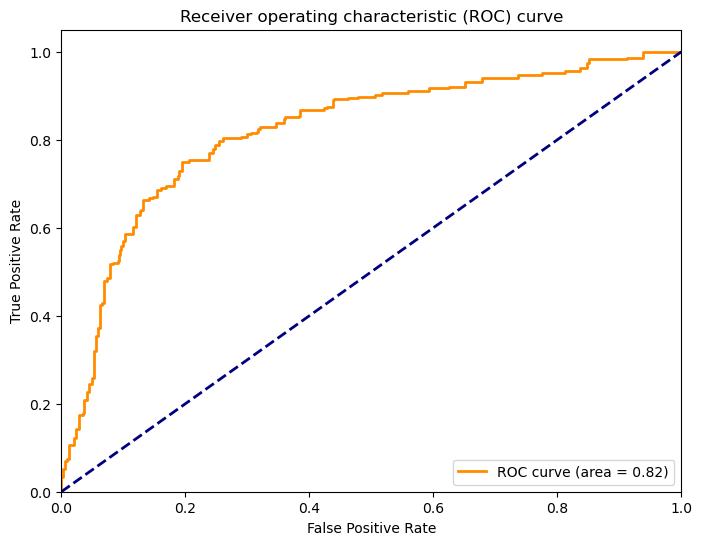

Accuracy: 0.7765108048365081
Coefficients:
AGE: -0.11902882167401842
WORKEDYR: -0.0033809869217087556
INCTOT: -7.231596935289223e-05
POVERTY: 0.006462598782156848
COLLEGEYRS: -0.046213796917406395
RCOST: -0.006198653781134626
Spread: -0.0020465189002743804
COMMUTES: -0.0028859778179140204
UNRATE: 0.011684315830541848
CONDO: -1.6860278596733202e-06
BIZ: 0.018598838166993575
RENTCPI: 2.897990119643121e-06
INEQ: 0.05333605138331748
RGDP: 9.250819081561776e-06
YIELD: 0.003364649155664718
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       367
         1.0       0.78      0.51      0.62       191

    accuracy                           0.78       558
   macro avg       0.78      0.72      0.73       558
weighted avg       0.78      0.78      0.77       558



In [146]:
logReg(dfTempDict, 'HHPOSITION','PERWT',penalty='12',C=1.0)

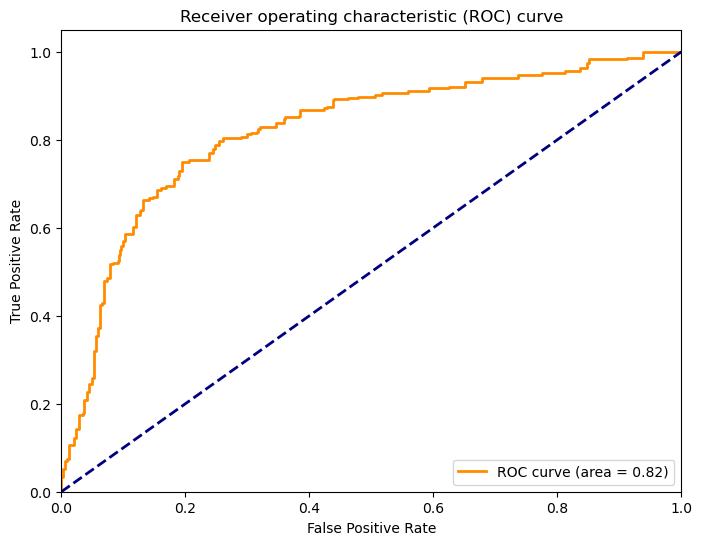

Accuracy: 0.7765108048365081
Coefficients:
AGE: -0.11902882167401842
WORKEDYR: -0.0033809869217087556
INCTOT: -7.231596935289223e-05
POVERTY: 0.006462598782156848
COLLEGEYRS: -0.046213796917406395
RCOST: -0.006198653781134626
Spread: -0.0020465189002743804
COMMUTES: -0.0028859778179140204
UNRATE: 0.011684315830541848
CONDO: -1.6860278596733202e-06
BIZ: 0.018598838166993575
RENTCPI: 2.897990119643121e-06
INEQ: 0.05333605138331748
RGDP: 9.250819081561776e-06
YIELD: 0.003364649155664718
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       367
         1.0       0.78      0.51      0.62       191

    accuracy                           0.78       558
   macro avg       0.78      0.72      0.73       558
weighted avg       0.78      0.78      0.77       558



In [158]:
logReg(dfTempDict, 'HHPOSITION','PERWT',penalty='12',C=2)

In [155]:
#Start after 2010 because INEQ starts then
dfTD_2010 = excludeVal(dfTemp,'YEAR',2005,'random')
dfTD_2010 = excludeVal(dfTD_2010,'YEAR',2006,'random')
dfTD_2010 = excludeVal(dfTD_2010,'YEAR',2007,'random')
dfTD_2010 = excludeVal(dfTD_2010,'YEAR',2008,'random')
dfTD_2010 = excludeVal(dfTD_2010,'YEAR',2009,'random')

#add dictionary
dfTD_2010 = dfDict(dfTD_2010, Fred_dict)

dropList = ['YEAR','NUMPREC','ROOMS','BUILTYEAR','Alone','ROOMATES','RENT']
dfTD_2010 = dfTD_2010.drop(dropList,axis=1)
dfTD_2010 = bool2Dummy(dfTD_2010)
dfTD_2010 = cleanInvalid(dfTD_2010)



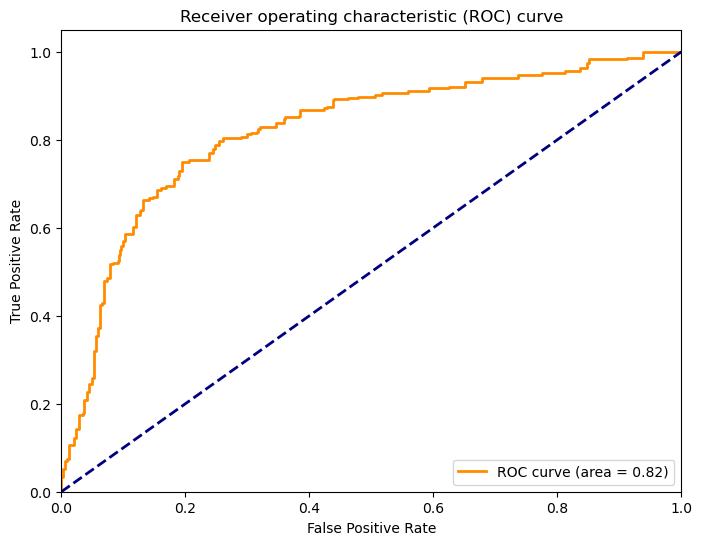

Accuracy: 0.7765108048365081
Coefficients:
AGE: -0.11902882167401842
WORKEDYR: -0.0033809869217087556
INCTOT: -7.231596935289223e-05
POVERTY: 0.006462598782156848
COLLEGEYRS: -0.046213796917406395
RCOST: -0.006198653781134626
Spread: -0.0020465189002743804
COMMUTES: -0.0028859778179140204
UNRATE: 0.011684315830541848
CONDO: -1.6860278596733202e-06
BIZ: 0.018598838166993575
RENTCPI: 2.897990119643121e-06
INEQ: 0.05333605138331748
RGDP: 9.250819081561776e-06
YIELD: 0.003364649155664718
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       367
         1.0       0.78      0.51      0.62       191

    accuracy                           0.78       558
   macro avg       0.78      0.72      0.73       558
weighted avg       0.78      0.78      0.77       558



In [156]:
logReg(dfTD_2010, 'HHPOSITION','PERWT',penalty='12',C=1.0)

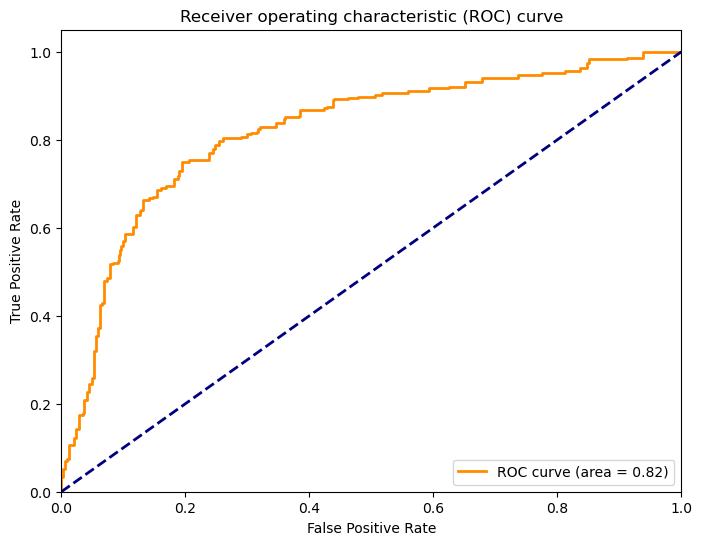

Accuracy: 0.7765108048365081
Coefficients:
AGE: -0.11902882167401842
WORKEDYR: -0.0033809869217087556
INCTOT: -7.231596935289223e-05
POVERTY: 0.006462598782156848
COLLEGEYRS: -0.046213796917406395
RCOST: -0.006198653781134626
Spread: -0.0020465189002743804
COMMUTES: -0.0028859778179140204
UNRATE: 0.011684315830541848
CONDO: -1.6860278596733202e-06
BIZ: 0.018598838166993575
RENTCPI: 2.897990119643121e-06
INEQ: 0.05333605138331748
RGDP: 9.250819081561776e-06
YIELD: 0.003364649155664718
              precision    recall  f1-score   support

         0.0       0.78      0.93      0.85       367
         1.0       0.78      0.51      0.62       191

    accuracy                           0.78       558
   macro avg       0.78      0.72      0.73       558
weighted avg       0.78      0.78      0.77       558



In [207]:
#test out different values of C and LASSO penalty
logReg(dfTempDict, 'HHPOSITION','PERWT',penalty='11',C=.5)

In [175]:
##Refresh
dfSpread.head()
dfTemp = df1.copy()
dfTemp = dfTemp.dropna(how='any')
print(list(dfTemp))
dfTemp.head()

['YEAR', 'NUMPREC', 'RENT', 'ROOMS', 'BUILTYEAR', 'PERWT', 'AGE', 'WORKEDYR', 'INCTOT', 'POVERTY', 'COLLEGEYRS', 'RCOST', 'Spread', 'COMMUTES', 'HHPOSITION', 'Alone', 'ROOMATES', 'FEMALE']


YEAR  NUMPREC    RENT  ROOMS  BUILTYEAR  PERWT   AGE  WORKEDYR   INCTOT  \
0  2005.0      1.0   840.0    3.0        5.0   52.0  22.0       3.0  28000.0   
2  2005.0      2.0  1500.0    6.0        5.0  146.0  27.0       3.0  81000.0   
3  2005.0      2.0  1500.0    6.0        5.0  145.0  27.0       3.0  35000.0   
4  2005.0      2.0   930.0    3.0        5.0   75.0  26.0       3.0  58000.0   
5  2005.0      2.0   930.0    3.0        5.0   83.0  27.0       3.0  65000.0   

   POVERTY  COLLEGEYRS     RCOST  Spread  COMMUTES  HHPOSITION  Alone  \
0    283.0         1.0  0.360000   140.0       1.0         0.0    1.0   
2    501.0         4.0  0.111111   125.0       1.0         0.0    0.0   
3    351.0         4.0  0.257143   125.0       1.0         0.0    0.0   
4    501.0         4.0  0.096207   155.0       1.0         0.0    0.0   
5    501.0         4.0  0.085846   155.0       1.0         0.0    0.0   

   ROOMATES  FEMALE  
0       0.0   False  
2       1.0   False  
3       0.0   False  
4       0.0   False  
5       0.0   False

In [184]:
#check before 2010
dfTD_2005 = dfTemp.copy()
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2010, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2011, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2012, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2013, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2014, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2015, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2016, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2017, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2018, 'random')
dfTD_2005 = excludeVal(dfTD_2005, 'YEAR', 2019, 'random')

#add dictionary
dfTD_2005 = dfDict(dfTD_2005, Fred_dict)

dropList = ['YEAR','NUMPREC','ROOMS','BUILTYEAR','Alone','ROOMATES','RENT','INEQ']
dfTD_2005 = dfTD_2005.drop(dropList,axis=1)
dfTD_2005 = bool2Dummy(dfTD_2005)
dfTD_2005 = cleanInvalid(dfTD_2005)

dfTD_2005.tail()

PERWT   AGE  WORKEDYR   INCTOT  POVERTY  COLLEGEYRS     RCOST  \
77217  112.0  25.0       3.0  26000.0    233.0         0.0  0.112821   
77218  152.0  23.0       3.0  10000.0     90.0         0.0  0.293333   
77222   33.0  31.0       3.0  60000.0    501.0         0.0  0.400000   
77224   64.0  23.0       3.0   8000.0    501.0         1.0  0.727500   
77226  131.0  33.0       3.0  38000.0    339.0         4.0  0.277895   

           Spread  COMMUTES  HHPOSITION    UNRATE     CONDO   BIZ   RENTCPI  \
77217    0.000000       1.0         0.0  8.366667 -0.006591 -2.65  0.001559   
77218    0.000000       1.0         0.0  8.366667 -0.006591 -2.65  0.001559   
77222  500.000000       1.0         0.0  8.366667 -0.006591 -2.65  0.001559   
77224   80.833333       1.0         1.0  8.366667 -0.006591 -2.65  0.001559   
77226   50.285714       1.0         0.0  8.366667 -0.006591 -2.65  0.001559   

           RGDP     YIELD  
77217  0.000237  2.304253  
77218  0.000237  2.304253  
77222  0.000237  2.304253  
77224  0.000237  2.304253  
77226  0.000237  2.304253

/Users/joanne/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


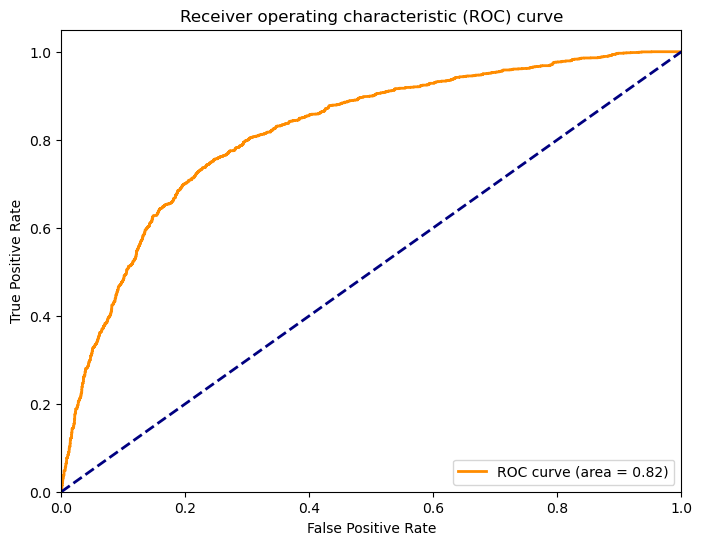

Accuracy: 0.7713402770325712
Coefficients:
AGE: -0.08326140951718687
WORKEDYR: 0.05363976800015714
INCTOT: -6.828027611057694e-05
POVERTY: 0.0067453852370785985
COLLEGEYRS: -0.19866327579006238
RCOST: -0.016307173483015577
Spread: -0.00305890969959797
COMMUTES: -0.01405754812151329
UNRATE: 0.2302811886987128
CONDO: -0.00043968788305801513
BIZ: 0.002632367670250927
RENTCPI: 7.036366787553763e-05
RGDP: -4.957181772296665e-05
YIELD: 0.05766688086147487
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      4507
         1.0       0.71      0.48      0.57      1834

    accuracy                           0.79      6341
   macro avg       0.76      0.70      0.72      6341
weighted avg       0.78      0.79      0.78      6341



In [185]:
logReg(dfTD_2005, 'HHPOSITION','PERWT',penalty='12',C=1.0)

/Users/joanne/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


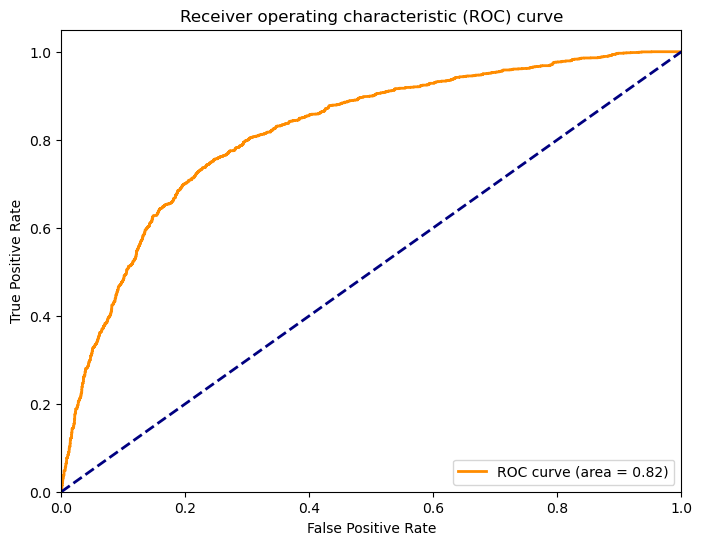

Accuracy: 0.7713402770325712
Coefficients:
AGE: -0.08326140951718687
WORKEDYR: 0.05363976800015714
INCTOT: -6.828027611057694e-05
POVERTY: 0.0067453852370785985
COLLEGEYRS: -0.19866327579006238
RCOST: -0.016307173483015577
Spread: -0.00305890969959797
COMMUTES: -0.01405754812151329
UNRATE: 0.2302811886987128
CONDO: -0.00043968788305801513
BIZ: 0.002632367670250927
RENTCPI: 7.036366787553763e-05
RGDP: -4.957181772296665e-05
YIELD: 0.05766688086147487
              precision    recall  f1-score   support

         0.0       0.81      0.92      0.86      4507
         1.0       0.71      0.48      0.57      1834

    accuracy                           0.79      6341
   macro avg       0.76      0.70      0.72      6341
weighted avg       0.78      0.79      0.78      6341



In [186]:
logReg(dfTD_2005, 'HHPOSITION','PERWT',penalty='12',C=2)

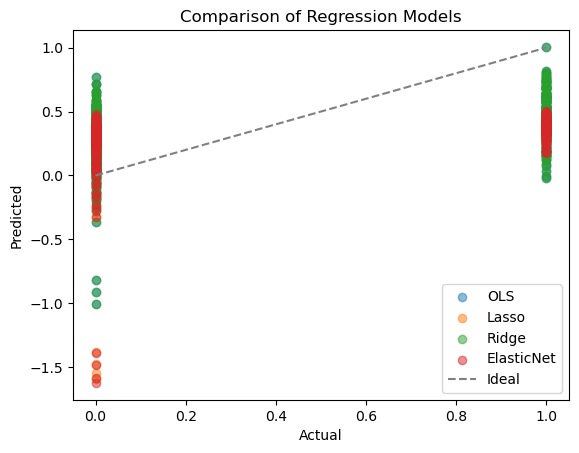

Regression coefficients:
                  OLS     Lasso     Ridge  ElasticNet
PERWT      -0.000239 -0.000099 -0.000239   -0.000147
AGE        -0.031357 -0.000000 -0.031357   -0.000000
WORKEDYR   -0.051570 -0.000000 -0.051570   -0.000000
INCTOT     -0.000002 -0.000004 -0.000002   -0.000004
POVERTY     0.000603  0.000231  0.000603    0.000265
COLLEGEYRS -0.053544 -0.000000 -0.053544   -0.000000
RCOST      -0.064444 -0.000000 -0.064438   -0.000000
Spread     -0.000110 -0.000114 -0.000110   -0.000163
COMMUTES   -0.090086 -0.000000 -0.090083   -0.000000
UNRATE      0.000000  0.000000  0.000000    0.000000
CONDO       0.000000  0.000000  0.000000    0.000000
BIZ         0.000000  0.000000  0.000000    0.000000
RENTCPI     0.000000  0.000000  0.000000    0.000000
INEQ        0.000000  0.000000  0.000000    0.000000
RGDP        0.000000  0.000000  0.000000    0.000000
YIELD       0.000000  0.000000  0.000000    0.000000

Test accuracy:
             Train R2   Test R2 Test RMSE
OLS         0.2

In [157]:
dfTempDict = cleanInvalid(dfTempDict)
compareRegW(dfTempDict,'HHPOSITION','PERWT')

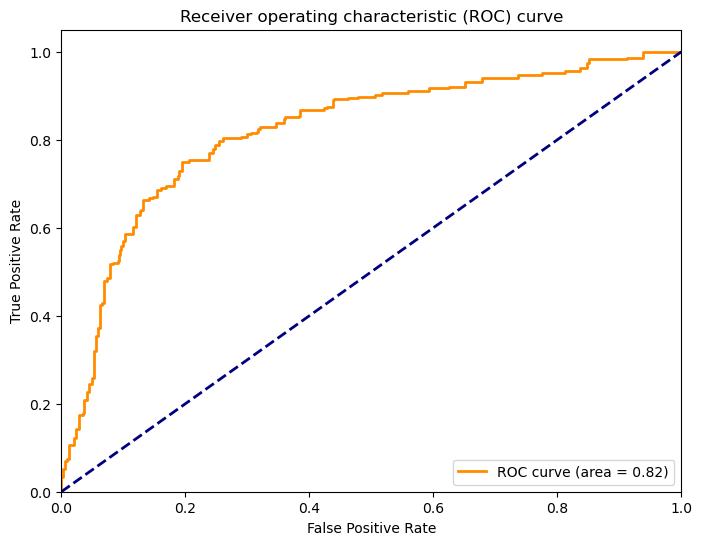

Accuracy: 0.7765108048365081
Coefficients:
AGE: -0.11902882167401842
WORKEDYR: -0.0033809869217087556
INCTOT: -7.231596935289223e-05
POVERTY: 0.006462598782156848
COLLEGEYRS: -0.046213796917406395
RCOST: -0.006198653781134626
Spread: -0.0020465189002743804
COMMUTES: -0.0028859778179140204
UNRATE: 0.011684315830541848
CONDO: -1.6860278596733202e-06
BIZ: 0.018598838166993575
RENTCPI: 2.897990119643121e-06
INEQ: 0.05333605138331748
RGDP: 9.250819081561776e-06
YIELD: 0.003364649155664718


In [99]:
logReg(dfTempDict, 'HHPOSITION','PERWT')

In [123]:
lasso_with_weights(dfTempDict, 'HHPOSITION','PERWT')

Accuracy Score: 75.09%
R^2 Value: -0.10649528510492612
RMSE Value: 0.4991031382914054
There are 10 coefficients that are exactly zero.


var  LASSO Coeff
0        PERWT    -0.000253
1          AGE    -0.024064
2     WORKEDYR    -0.000000
3       INCTOT    -0.000002
4      POVERTY     0.000441
5   COLLEGEYRS    -0.024536
6        RCOST    -0.000000
7       Spread    -0.000206
8     COMMUTES    -0.000000
9       UNRATE     0.000000
10       CONDO     0.000000
11         BIZ     0.000000
12     RENTCPI     0.000000
13        INEQ     0.000000
14        RGDP     0.000000
15       YIELD     0.000000

Feature importances:
INCTOT        0.198439
POVERTY       0.160019
AGE           0.141800
RCOST         0.140597
PERWT         0.140337
Spread        0.109730
COLLEGEYRS    0.077343
COMMUTES      0.016073
WORKEDYR      0.015661
UNRATE        0.000000
dtype: float64

In-sample accuracy: 0.9747
Out-of-sample accuracy: 0.7914
Mean absolute error: 0.2043
Mean squared error: 0.2043
Root mean squared error: 0.4520
F1 score: 0.7092


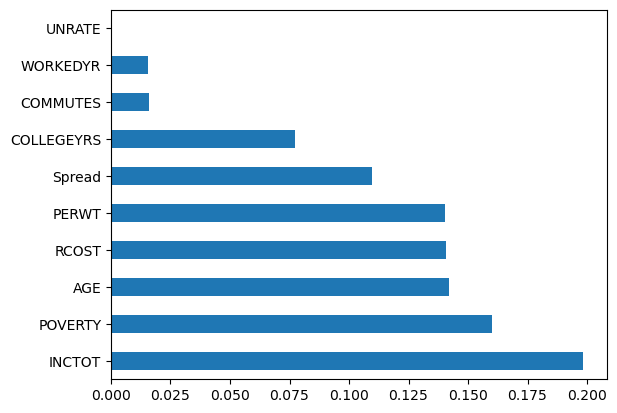

RandomForestClassifier(max_features='sqrt', n_estimators=5)

In [223]:
run_random_forest(dfTempDict,'PERWT','HHPOSITION')

In [224]:
dfTempDict.shape[0]

2789

In [ ]:
dropList = ['']
dfTD_v1 = dfTempDict.drop(dropList,axis=1)